# Automated Time Series Using Prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet

This notebook will show tools that can automate prediction of a time series using a state-of-art models. Thus, **it will be faster, but less flexibility**. Some models include:

- Pmdarima—http://alkaline-ml.com/pmdarima/modules/classes.html
- Prophet—https://facebook.github.io/prophet
- NeuralProphet—https://neuralprophet.com/html/index.html
- PyTorch Forecasting—https://pytorch-forecasting.readthedocs.io/en/stable

For this notebook, this will focus on **Prophet model** by Facebook researchers.

## Introduction About Prophet

$y(t) = g(t) + s(t) + h(t) + \epsilon_t $

The model of Prophet is pretty straight-forward, modeled as a linear combination of:

- Trend $g(t)$
- Seasonal component $s(t)$
- Holiday effect $h(t)$ 
- Error term $\epsilon_t$

But, the **Prophet model doesn't take account the previous past data like ARIMA**. So instead of underlying process, this algorithm is more into fitting data to the curve. More of the...

Advantages:
- Robust to outliers and missing data, suitable in **business context**
- Very flexible, as it can accomodate multiple seasonal periods and changing trends
- Works best with time series that have a strong seasonal effect with several seasons of historical data

Disadvantages:
- Doesn't take into account of the past data
- Thus, there will be some loss of predictive information

For more information on how the mathematical/underlying algorithm of Prophet works, read <a href="https://peerj.com/ preprints/3190/">Forecasting at Scale</a> by Taylor and Letham (2017).

## Table of Contents

1. Data Cleaning & Pre-processing
2. Univariate Forecasting
3. Multivariate Forecasting

The robust-forecasting process include:
- Data pre-processing (train-test split)
- Fitting the model
- Hyperparameter tuning
- Evaluate the model performance using cross-validation

## Data Cleaning & Pre-Processing

The hands-on activity here is using <a href='https://www.kaggle.com/c/store-sales-time-series-forecasting'>Store Sales - Time Series Forecasting</a> competition from Kaggle. The data here is used to predict sales for the thousands of product families sold at Favorita stores located in Ecuador. Please refer to the link to learn more about the data.

In [2]:
df = pd.read_csv('train.csv')

display(df.head(5))
print('len of the dataframe:', len(df))

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


len of the dataframe: 3000888


    Merging Store to Main Data Set

In [3]:
store_df = pd.read_csv('stores.csv')

display(store_df.head(5))
print('len of the dataframe:', len(store_df))

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


len of the dataframe: 54


In [4]:
df = df.merge(store_df, on='store_nbr', how='left')
df = df.rename(columns={'type': 'type_store'})

# change data format to pd.DatetimeIndex

display(df.head(5))
print('len of the dataframe:', len(df))

,id,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


len of the dataframe: 3000888


    Merging Holiday to Main Data Set

In [5]:
holiday_df = pd.read_csv('holidays_events.csv')

display(holiday_df.head(5))
print('len of the dataframe:', len(holiday_df))

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


len of the dataframe: 350


In [6]:
holiday_df = holiday_df[~holiday_df['transferred'] == True]
holiday_df = holiday_df.drop(['description', 'transferred'], axis=1)

# renaming based on the manual of the data set

holiday_df['type'] = holiday_df['type'].replace({'Transfer': 'Holiday',
                                                 'Bridge': 'Holiday',
                                                 'Additional': 'Holiday'})

holiday_df = holiday_df[~holiday_df.duplicated()]
holiday_df = holiday_df[~(holiday_df['type'] == 'Work Day')]

display(holiday_df.head(5))
print('len of the dataframe:', len(holiday_df))

,date,type,locale,locale_name
0,2012-03-02,Holiday,Local,Manta
1,2012-04-01,Holiday,Regional,Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca
3,2012-04-14,Holiday,Local,Libertad
4,2012-04-21,Holiday,Local,Riobamba


len of the dataframe: 328


In [7]:
df = df.merge(holiday_df, on='date', how='left')

df['type'].fillna('Work Day', inplace=True)
df['locale'].fillna('National', inplace=True)
df['locale_name'].fillna('Ecuador', inplace=True)

display(df.head(5))
print('len of the dataframe:', len(df))

,id,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,type,locale,locale_name
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador


len of the dataframe: 3047220


    Merging Oil Price to Main Data Set

In [8]:
oil_csv = pd.read_csv('oil.csv')
oil_csv.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
# filling na value
# by averaging value of n+1 and n-1, where n is the index location where the value is na

for i in oil_csv[oil_csv['dcoilwtico'].isna()].index:
    if i == 0:
        oil_csv.loc[i, 'dcoilwtico'] = oil_csv.loc[i+1, 'dcoilwtico']
    else:
        
        i_n = i
        i_p = i
        while np.isnan(oil_csv.loc[i_n-1, 'dcoilwtico']):
            i_n -= 1
        while np.isnan(oil_csv.loc[i_p+1, 'dcoilwtico']):
            i_p += 1
        
        oil_csv.loc[i, 'dcoilwtico'] = (oil_csv.loc[i_n-1, 'dcoilwtico'] + oil_csv.loc[i_p+1, 'dcoilwtico']) / 2

In [10]:
oil_df = pd.DataFrame(columns=['date'])

oil_df['date'] = pd.date_range(start='1/1/2013', end='08/15/2017')
oil_df['date'] = oil_df['date'].dt.strftime('%Y-%m-%d')  # convert it back to string to make it an uniform data all over the row

oil_df = oil_df.merge(oil_csv, on='date', how='left')

for i in range(len(oil_df)):
    if np.isnan(oil_df.loc[i, 'dcoilwtico']):
        oil_df.loc[i, 'dcoilwtico'] = oil_df.loc[i-1, 'dcoilwtico']
  
oil_df.head(10)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
5,2013-01-06,93.12
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [11]:
df = df.merge(oil_df, on='date', how='left')

display(df.head(5))
print('len of the dataframe:', len(df))

,id,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,type,locale,locale_name,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,93.14


len of the dataframe: 3047220


In [12]:
for i in range(len(oil_df)):
    if np.isnan(df.loc[i, 'dcoilwtico']):
        df.loc[i, 'dcoilwtico'] = df.loc[i-1, 'dcoilwtico']

In [13]:
# finishing up

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['day_of_week'] = df['date'].dt.day_name()

weekend_mask = df['day_of_week'].isin(['Saturday', 'Sunday'])
workday_mask = df['type'] == 'Work Day'

df.loc[weekend_mask & workday_mask, 'type'] = 'Weekend'

In [14]:
df[df['type'] == 'Weekend']['day_of_week'].unique()

array(['Saturday', 'Sunday'], dtype=object)

### Exploratory Data Analysis

    Aggregated Data

In [15]:
df.drop(['id', 'store_nbr'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
sales,3047220.0,358.721770,1106.594136,0.00,0.00,11.00,196.00,124717.00
onpromotion,3047220.0,2.611611,12.239126,0.00,0.00,0.00,0.00,741.00
cluster,3047220.0,8.481481,4.649735,1.00,4.00,8.50,13.00,17.00
dcoilwtico,3047220.0,67.899308,25.674983,26.19,46.37,53.41,95.72,110.62


In [16]:
df.drop(['id', 'store_nbr'], axis=1).describe(include='object').T

,count,unique,top,freq
family,3047220,33,AUTOMOTIVE,92340
city,3047220,22,Quito,1015740
state,3047220,16,Pichincha,1072170
type_store,3047220,5,D,1015740
type,3047220,4,Work Day,1837242
locale,3047220,3,National,2811996
locale_name,3047220,24,Ecuador,2811996
day_of_week,3047220,7,Thursday,438372


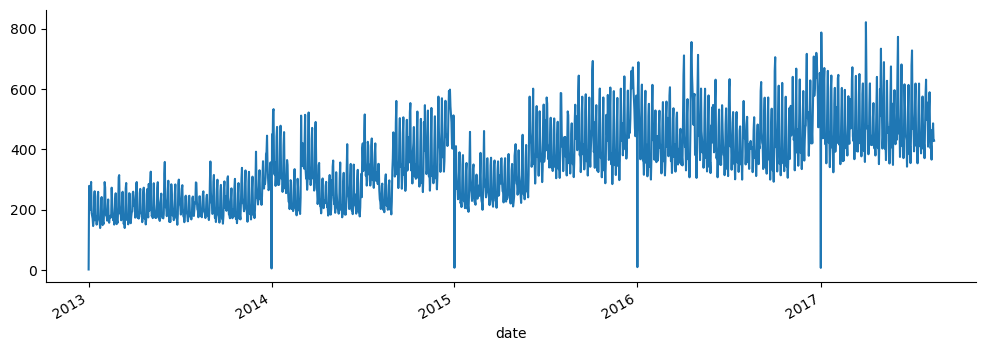

In [17]:
df.groupby('date').agg('mean')['sales'].plot(figsize=(12,4))
sns.despine()

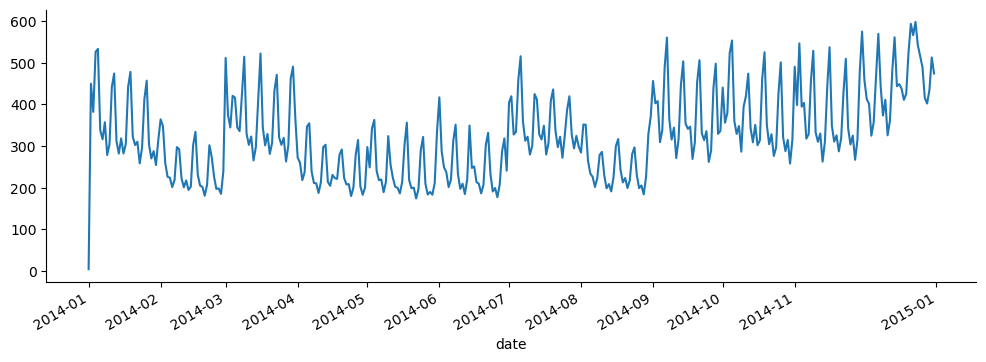

In [18]:
# cyclical by year
# taking example of 2014

import matplotlib.dates as mdates

ax = plt.gca()
ax = df[(df['date'] > '2013-12-31') & (df['date'] < '2015-01-01')].groupby('date').agg('mean')['sales'].plot(figsize=(12,4))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,1)))

sns.despine()

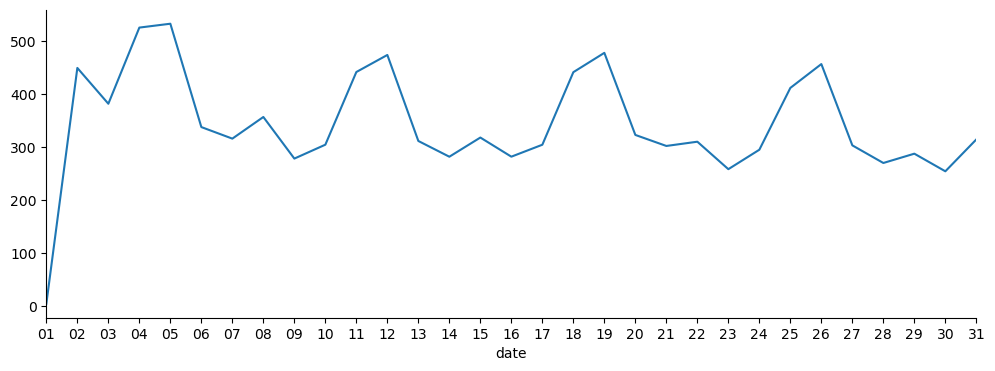

In [19]:
# cyclical by month, showing xticks by every date
# taking example of january, 2014

import matplotlib.dates as mdates

ax = plt.gca()
ax = df[(df['date'] > '2013-12-31') & (df['date'] < '2014-02-01')].groupby('date').agg('mean')['sales'].plot(figsize=(12,4))

# change x ticks to name of the day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

sns.despine()

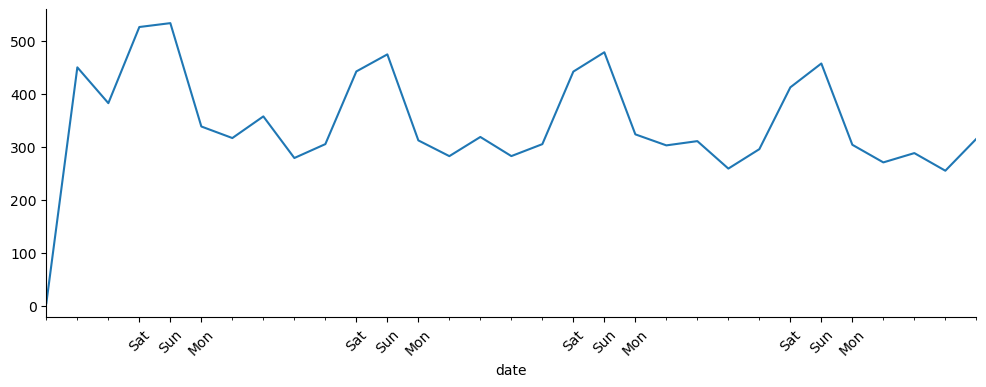

In [20]:
# cyclical by month, showing xticks by days
# taking example of january, 2014

import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

ax = plt.gca()
ax = df[(df['date'] > '2013-12-31') & (df['date'] < '2014-02-01')].groupby('date').agg('mean')['sales'].plot(figsize=(12,4))

# change x ticks to name of the day
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(SA, SU, MO)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.xticks(rotation=45)

sns.despine()

    Sales vs. Oil Price Data

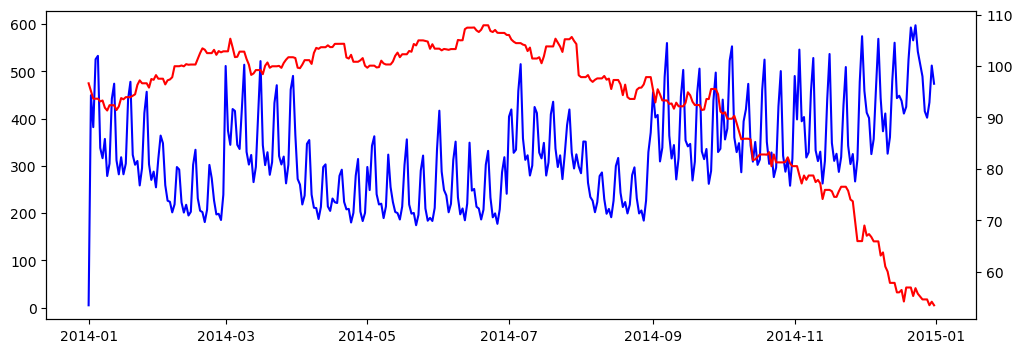

In [21]:
temp = df[(df['date'] > '2013-12-31') & (df['date'] < '2015-01-01')]

temp_index = temp.groupby('date').agg('mean')['sales'].index
temp_sales = temp.groupby('date').agg('mean')['sales']
temp_oil = temp.groupby('date').agg('mean')['dcoilwtico']

fig, ax = plt.subplots(figsize=(12,4))
ax2 = ax.twinx()

ax.plot(temp_index, temp_sales, color='blue')
ax2.plot(temp_index, temp_oil, color='red')

    Granular Data

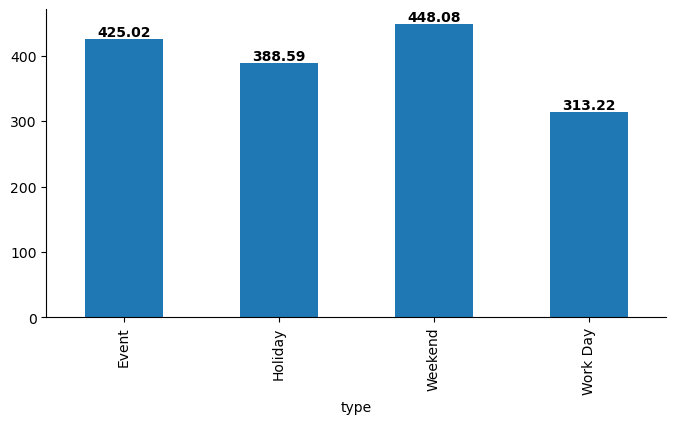

In [22]:
# groping sales by the type of the day on its mean

temp = df.groupby('type').agg('mean')['sales']
temp.plot(kind='bar', figsize=(8,4))

# give annotation to the text
for i, val in enumerate(temp):
    plt.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
sns.despine()

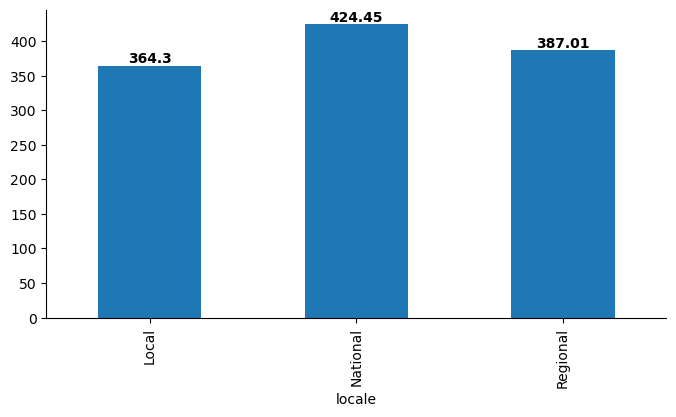

In [23]:
# groping sales by the type of the holiday on its mean

temp = df[df['type'] == 'Holiday'].groupby('locale').agg('mean')['sales'] 
temp.plot(kind='bar', figsize=(8,4))

for i, val in enumerate(temp):
    plt.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
sns.despine()

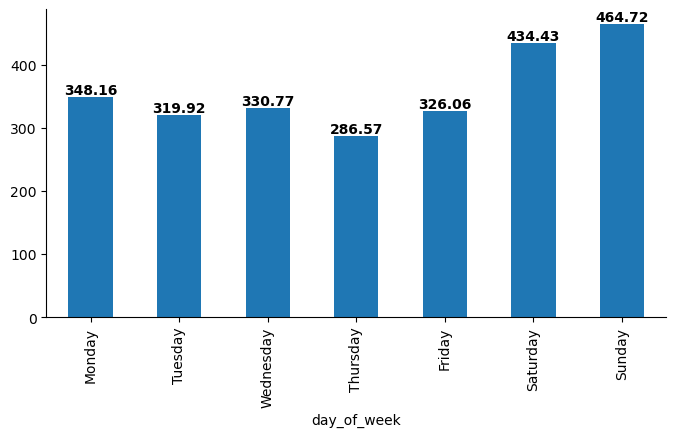

In [24]:
# groping sales by the day on its mean

temp = df.groupby('day_of_week').agg('mean')['sales'].reindex(['Monday', 'Tuesday', 'Wednesday',
                                                               'Thursday', 'Friday', 'Saturday', 'Sunday'])
temp.plot(kind='bar', figsize=(8,4))

for i, val in enumerate(temp):
    plt.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
sns.despine()

Hypothesis so far, **sales will go up** during:

- Weekends 
- Holiday, Weekend, Event

# Hands-On: Facebook Prophet in Action 

## Univariate Analysis

In [25]:
prophet_df = df.groupby('date').agg('mean')['sales'].reset_index()
prophet_df.head(5)

,date,sales
0,2013-01-01,1.409438
1,2013-01-02,278.390807
2,2013-01-03,202.840197
3,2013-01-04,198.911154
4,2013-01-05,267.873244


1. Prophet expects to have only **two columns**:
- ds: A date column
- y: Column for the value

In [26]:
prophet_df.columns = ['ds', 'y']
prophet_df.columns

Index(['ds', 'y'], dtype='object')

2. Splitting the data into training and test data set
- Training: 2013 - 2015 data
- Test: 2016 - 2018 data

In [27]:
train = prophet_df[prophet_df['ds'] < '2016-01-01']
test = prophet_df[prophet_df['ds'] >= '2016-01-01']

3. Fitting the model

Following the sklearn API structure.

In [28]:
# initiate the model to the variable
m = Prophet()

# fitting the model to train data frame
m.fit(train)

# make a dataframe container for the prediction
# 592 is from the length of the test dataframe we have
future = m.make_future_dataframe(periods=592)

# generate the forecast using predict method
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2200.24    0.00961289       194.635      0.4173           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2204.69   8.11644e-07       66.5079      0.4855           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       2204.69   1.53522e-07       62.8443           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [29]:
forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,204.235260,154.675260,294.887938,204.235260,204.235260,20.419445,20.419445,20.419445,-34.271859,-34.271859,-34.271859,54.691304,54.691304,54.691304,0.0,0.0,0.0,224.654705
1,2013-01-02,204.327479,159.301840,298.421688,204.327479,204.327479,24.419376,24.419376,24.419376,-24.062477,-24.062477,-24.062477,48.481853,48.481853,48.481853,0.0,0.0,0.0,228.746855
2,2013-01-03,204.419698,112.351214,252.782537,204.419698,204.419698,-19.742032,-19.742032,-19.742032,-62.069345,-62.069345,-62.069345,42.327313,42.327313,42.327313,0.0,0.0,0.0,184.677666
3,2013-01-04,204.511917,144.528742,278.352400,204.511917,204.511917,5.908252,5.908252,5.908252,-30.408012,-30.408012,-30.408012,36.316265,36.316265,36.316265,0.0,0.0,0.0,210.420169
4,2013-01-05,204.604135,235.070932,367.181736,204.604135,204.604135,97.581796,97.581796,97.581796,67.051461,67.051461,67.051461,30.530335,30.530335,30.530335,0.0,0.0,0.0,302.185931


### Interpreting the Result

- ds: datestamp
- yhat: the value of the forecast
- yhat_lower: lower bound of the forecast, with 80% of confidence interval
- yhat_upper: upper bound of the forecast, with 80% of confidence interval

In [30]:
# merging forecast data to the test data
# for evaluating the performance of the data we have

test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_4483/2022442779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_4483/2022442779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_4483/2022442779

    Overall Plot

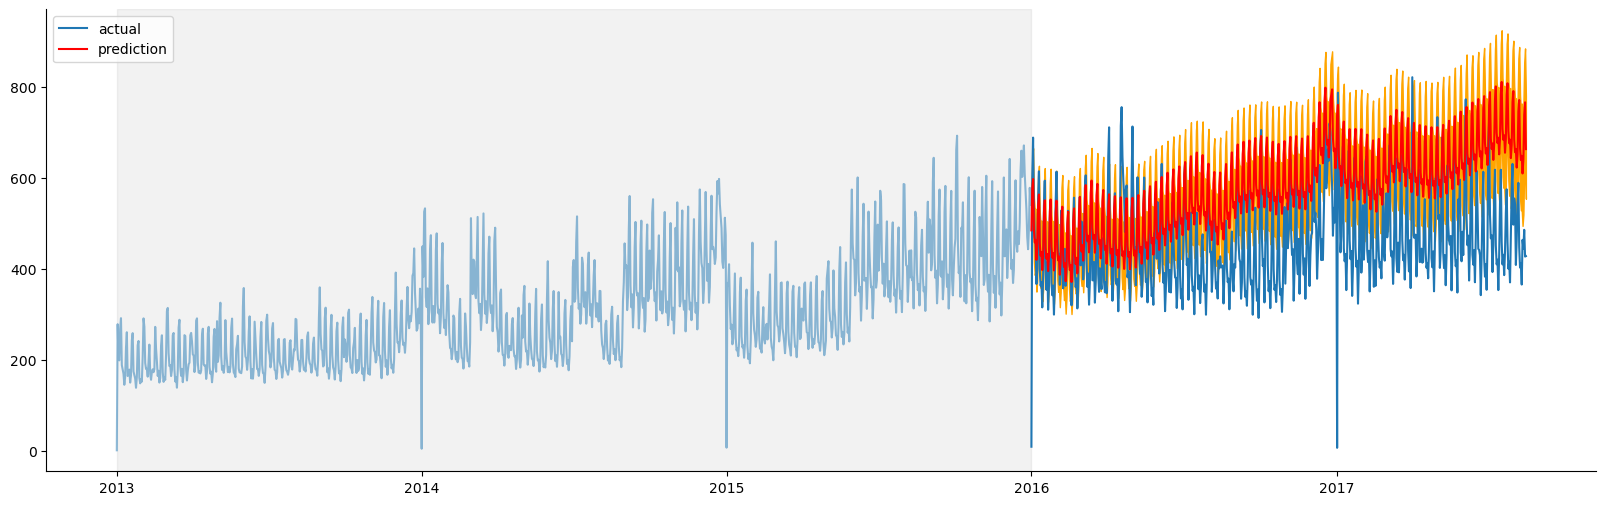

In [31]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(train['ds'], train['y'], alpha=0.5)
ax.plot(test['ds'], test['y'], color='tab:blue', label='actual')
ax.plot(test['ds'], test['yhat'], color='red', label='prediction')

plt.fill_between(x=test['ds'], y1=test['yhat_lower'], y2=test['yhat_upper'], color='orange')

ax.axvspan(train['ds'].min(), train['ds'].max(), color='#808080', alpha=0.1)

plt.legend(loc='upper left')
sns.despine()

    Zoom In to The Plot

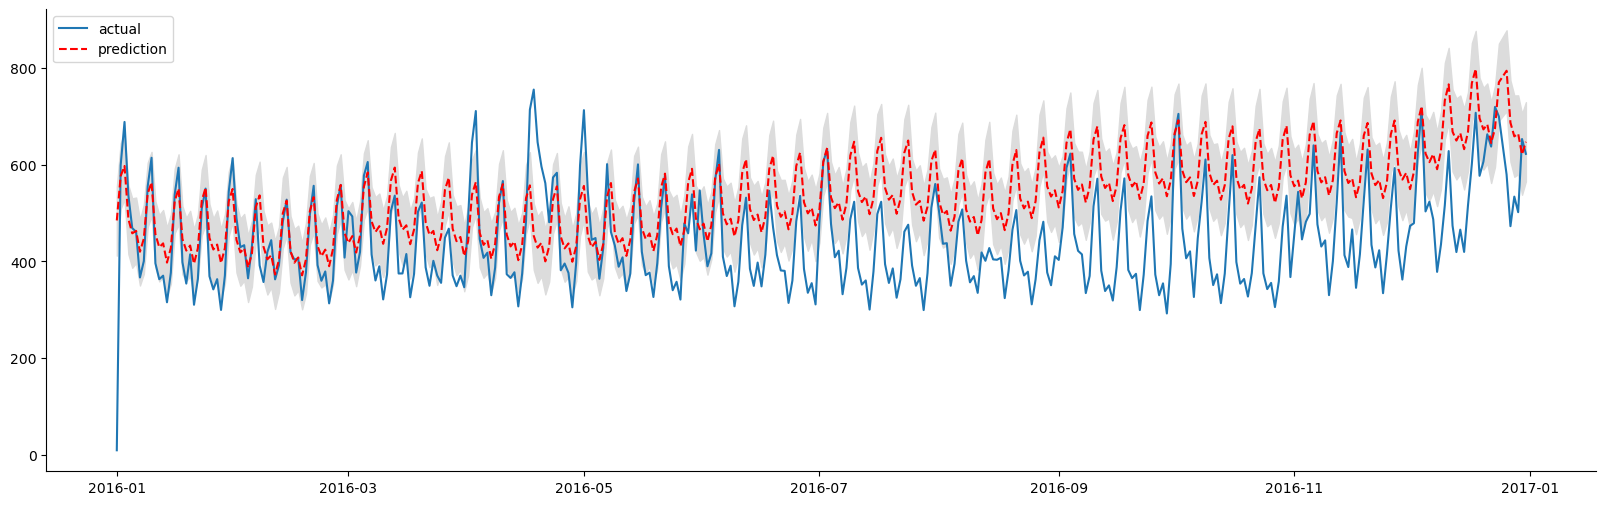

In [32]:
# plotting for only 1 year cycle
# throughout 2016 - 2017

temp = test[test['ds'] < '2017-01-01']

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(temp['ds'], temp['y'], color='tab:blue', label='actual')
ax.plot(temp['ds'], temp['yhat'], color='red', label='prediction', ls='--')

plt.fill_between(x=temp['ds'], y1=temp['yhat_lower'], y2=temp['yhat_upper'], color='gainsboro')

plt.legend(loc='upper left')
sns.despine()

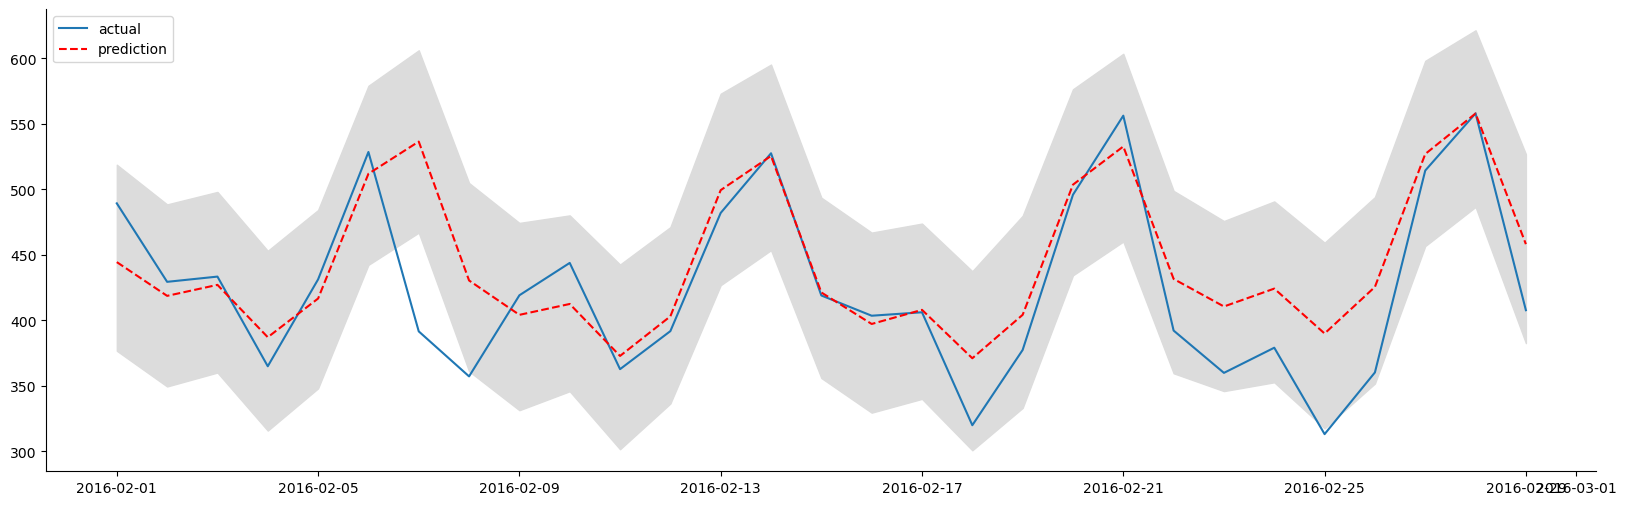

In [33]:
# to a month
# example using february 2016

temp = test.copy(deep=True)
temp['ds'] = pd.to_datetime(temp['ds'])
temp = temp[(temp['ds'] >= '2016-02-01') & (temp['ds'] < '2016-03-01')]

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(temp['ds'], temp['y'], color='tab:blue', label='actual')
ax.plot(temp['ds'], temp['yhat'], color='red', label='prediction', ls='--')

plt.fill_between(x=temp['ds'], y1=temp['yhat_lower'], y2=temp['yhat_upper'], color='gainsboro')

plt.legend(loc='upper left')
sns.despine()

## Advanced Functionality

### Visualization

    Forecasted Data

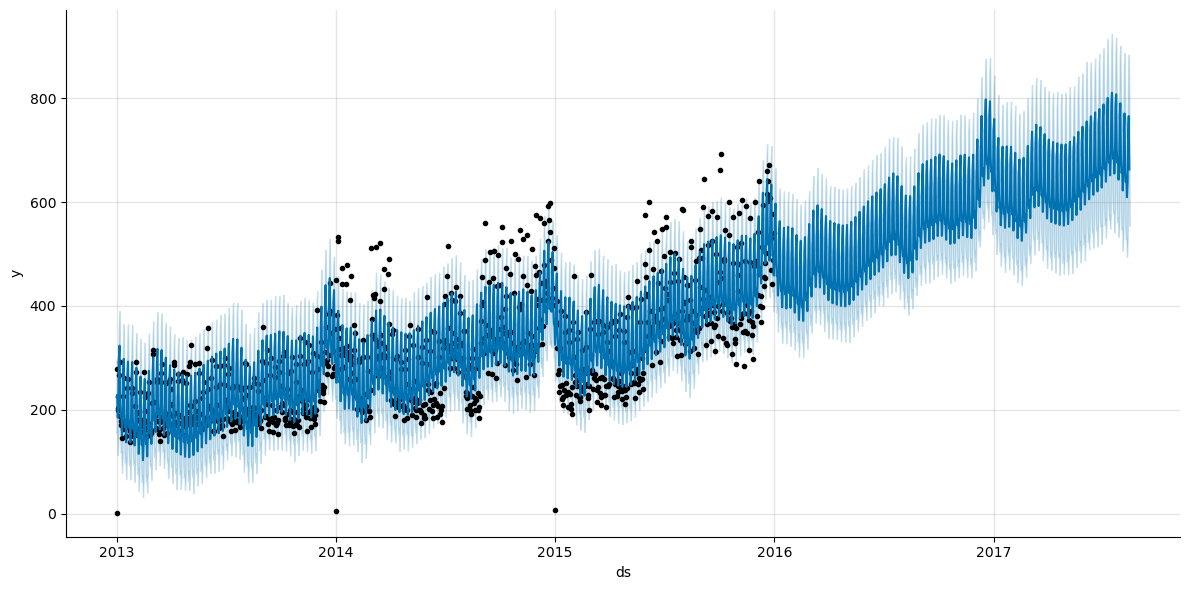

In [34]:
# quickly generate the forecasted data using plot method

# BLACK DOTS represents the training data points
# SOLID LINE represents the predicted data
# SHADED BAND represents the 80% of confidence interval area

m.plot(forecast, figsize=(12,6));
sns.despine()

    Components of the Data

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


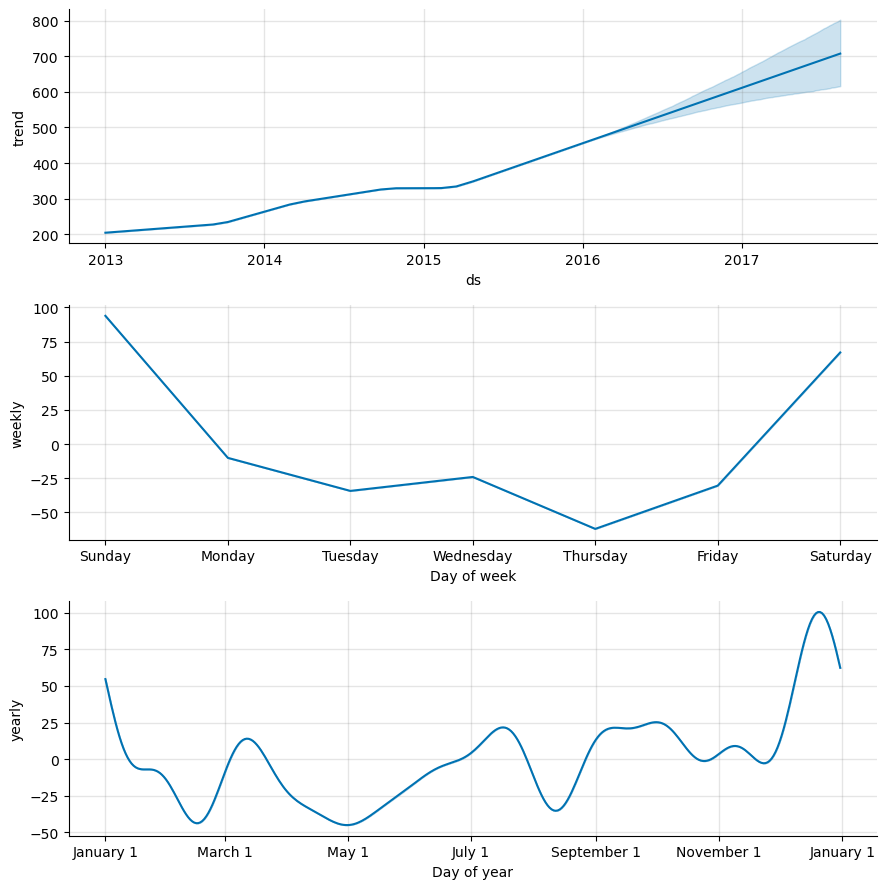

In [35]:
m.plot_components(forecast)
sns.despine()

    Identify Trend Change Points

- **Vertical dashed line:** Point where the trend changes
- **Curved red line:** Trend component of the time series

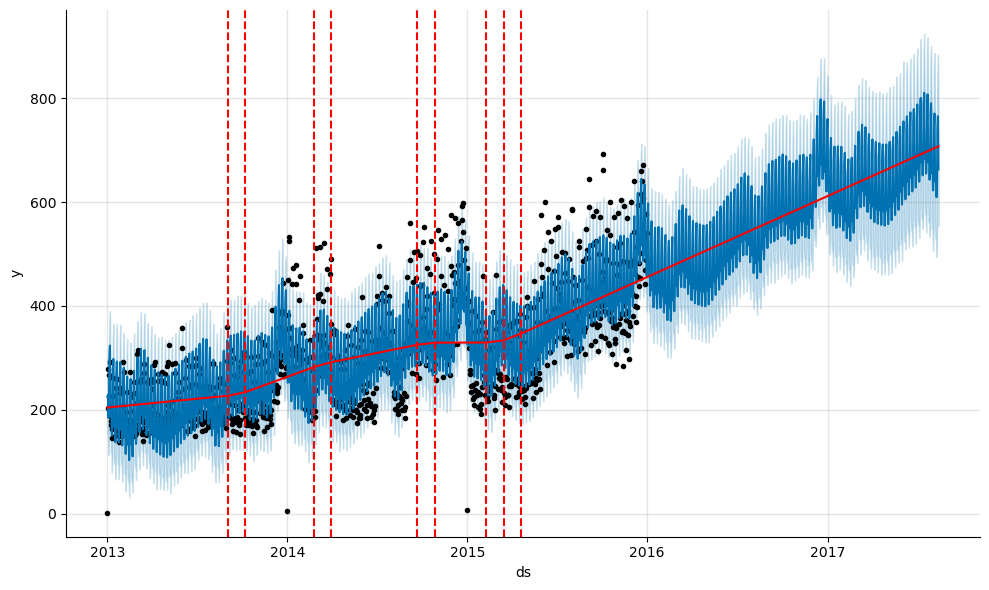

In [36]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
sns.despine()

### Cross-Validation and Performance Metrics

Method to evaluate the model performance. It is to achieve a stable model of a time series by evaluating the model performance with a different set of testing data set. For an important note, **the goal of cross-validation is not to optimize the model's parameter**. So, when setting the parameter for cross validation, choose values that are appropriate for the specific problem you are trying to solve and that represent a realistic scenario.

For Prophet, the way it works is similar to rolling forecast, but with a different purpose. Parameters that have to be set:

- **Initial:** Length of the training dataset
- **Period:** Cut off for the validation dataset, how much data to add to the training data set in every iteration of cross-validation
- **Horizon:** Length of the forecast dataset, how far out it will forecast

To make it simpler, we can follow the formula below:

- $period = horizon$
- $initial = total days - num folds * horizon$

If it's still confusing, <a href='https://stackoverflow.com/questions/63780573/trying-to-understand-fb-prophet-cross-validation'>this thread</a> from stackoverflow.com would help or read the book **Page 376**.

<br>*NOTES: Initial + Horizon could be not longer than the training data set we have.*

    Hands-On Activity:

Examples:
- The initial model will be trained on the first 1,825 days of data.
- It will forecast the next 60 days of data (because horizon is set to 60). 
- The model will then train on the initial period + the period (1,825 + 30 days in this case) and forecast the next 60 days. 
- It will continued like this, adding another 30 days to the training data and then forecasting for the next 60 until there is no longer enough data to do this.

1. Make the dataframe for the cross validation

In [41]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(m,
                         initial='365 days',    # use the initial 365 days of the dataset
                         period='180 days',     # shifting period after the first training would be 180 days
                         horizon='365 days')    # use that to forecast the next 365 days

df_cv

INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       843.189     0.0110024       137.855           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       845.631   0.000817383       123.153   8.448e-06       0.001      274  LS failed, Hessian reset 
     199       845.711   0.000119921       85.8426      0.6001      0.6001      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       845.787   1.13155e-07       98.4983   1.173e-09       0.001      410  LS failed, Hessian reset 
     273       845.787   3.29327e-08       105.281      0.1791      0.8082      420   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       1145.85   0.000697878       131.204   7.398e-06       0.001      119  LS failed, Hessian reset 
      77       1145.92   4.97141e-06       47.0026   1.041e-07       0.001      189  LS failed, Hessian reset 
      99       1145.92    4.4861e-06       57.5079           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       1146.43     0.0005864       101.171   4.656e-06       0.001      325  LS failed, Hessian reset 
     189        1146.8   2.85609e-05       53.3142   6.533e-07       0.001      413  LS failed, Hessian reset 
     199        1146.8   1.52745e-05       62.1851      0.9383      0.9383      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       1146.81     3.933e-05       56.4211   7.422e-07   

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1514.13   9.02185e-05       74.1878      0.4073           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       1514.91    0.00227142       172.347   1.693e-05       0.001      289  LS failed, Hessian reset 
     199        1515.1   0.000410621       77.3169           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1515.37   0.000398425       80.8875   4.924e-06       0.001      466  LS failed, Hessian reset 
     299       1515.43   6.59298e-05       74.8773           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384       1515.51   1.32753e-06       70.7172   1.645e-08       0.001      631  LS failed, Hessian reset

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-06,352.837367,311.383609,396.305851,337.973380,2014-01-05
1,2014-01-07,329.408086,288.656773,371.002340,316.190011,2014-01-05
2,2014-01-08,334.645892,294.909918,374.318333,357.001601,2014-01-05
3,2014-01-09,323.129791,277.689957,365.388713,278.551029,2014-01-05
4,2014-01-10,343.327739,299.741987,384.186791,304.744854,2014-01-05
...,...,...,...,...,...,...
1087,2015-12-27,814.763503,741.983041,883.764775,470.097716,2014-12-31
1088,2015-12-28,724.704164,649.539065,792.579853,443.145293,2014-12-31
1089,2015-12-29,700.974958,629.326843,772.262071,488.643112,2014-12-31
1090,2015-12-30,709.650454,638.707383,780.135656,578.026788,2014-12-31


2. Use the performance metrics to evaluate the performance of the model over the multiple forecasting periods

In [42]:
from fbprophet.diagnostics import performance_metrics

df_perf = performance_metrics(df_cv, rolling_window=0)

# rolling_window = 0 -> each evaluation metric is computer for each forecast point

display(df_perf.head(5))
display(df_perf.tail(5))

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,69657.400460,263.926885,193.482888,20.521562,0.275974,0.333333
1,2 days,12909.455637,113.619785,94.183320,0.213999,0.273285,0.333333
2,3 days,16416.694086,128.127648,105.994239,0.292945,0.272245,0.333333
3,4 days,12630.066378,112.383568,97.815212,0.274521,0.239042,0.333333
4,5 days,12656.303727,112.500239,97.123478,0.305231,0.244458,0.333333


,horizon,mse,rmse,mae,mape,mdape,coverage
360,361 days,117045.610655,342.119293,306.000739,22.239439,0.733179,0.0
361,362 days,47821.583323,218.681465,209.772247,0.475358,0.436504,0.0
362,363 days,36343.804977,190.640512,186.828741,0.453744,0.434534,0.0
363,364 days,24571.405419,156.752689,155.227485,0.340790,0.345500,0.0
364,365 days,33437.598222,182.859504,180.707154,0.412783,0.351710,0.0


3. Plot the cross validation dataframe to see whether the error is constant or not

- The result would be good if the line is fairly flat, which means that we have a stable model where the error doesn't increase as it predicts further in time. 
- If not then: **Revise the forecast horizon** or make sure we're comfortable with the error.

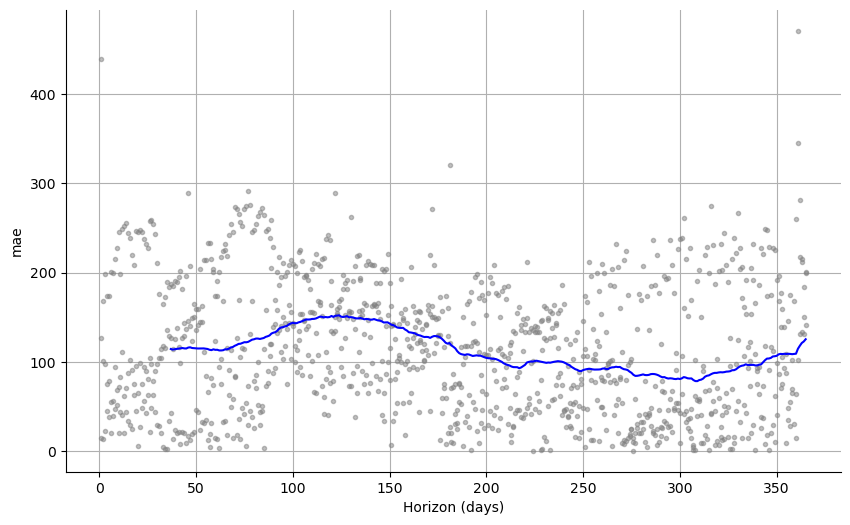

In [43]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='mae');
sns.despine()

### Hyperparameter Tuning (HPT)

Parameters that people usually tune and adjust, where usually it sets:

- **changepoint_prior_scale**: Flexibility of the trend, and particulary how much the trend changes at the trend change-points -> too small will underfit and ignore noises, too high will be overfit to noise
- **seasonality_prior_scale**: Flexibility of the seasonality -> Large value allows the seasonal component to fit smaller fluctuations
- **holidays_prior_sclae**: Flexibility of the holiday effects
- **seasonality_mode**: Additive or multiplicative. Change to multiplicative tf the seasonal fluctuation gets larger over time

    Hands-On: Looking for the best parameter combination

In [64]:
# make all combinations for the parameters

from itertools import product

param_grids = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],     # range of the parameter that usually adjusted
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],      # range of the parameter that usually adjusted 
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],          # in the book it's only until seasonality_prior_scale
    'seasonality_mode': ['additive', 'multiplicative']
}

# the line below generates all possible combinations of the parameter values in param_grids, which gives a list of tuples where each tuple corresponds to a set of values for the parameters.
# list comprehension is used to convert each tuple of parameter values into a dictionary where the keys are the parameter names and the values are the corresponding values from the tuple.

all_params = [dict(zip(param_grids.keys(), v)) for v in product(*param_grids.values())]
display(all_params[:5])
print('total combinations:', len(all_params))

[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.1,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.1,
  'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 1.0,
  'seasonality_mode': 'additive'}]

total combinations: 128


In [65]:
# we'll make a simple param_grids, as it takes really long to looping total of 128 combinations
# by deleting holidays prior scale and seasonality mode
# in total, we only have 16 combinations

param_grids_simple = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],     # range of the parameter that usually adjusted
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],      # range of the parameter that usually adjusted 
}

# the line below generates all possible combinations of the parameter values in param_grids, which gives a list of tuples where each tuple corresponds to a set of values for the parameters.
# list comprehension is used to convert each tuple of parameter values into a dictionary where the keys are the parameter names and the values are the corresponding values from the tuple.

all_params_simple = [dict(zip(param_grids_simple.keys(), v)) for v in product(*param_grids_simple.values())]
display(all_params_simple[:5])
print('total combinations:', len(all_params_simple))

[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}]

total combinations: 16


So, in total, the process would be:

1. Fitting the model with setting the parameters
2. Cross validation to evaluate the performance of the model
3. Use performance metrics to calculate the MAE for every forecasted data

In [68]:
from tqdm import tqdm  # to monitor for-loop progress

maes = []

for params in tqdm(all_params_simple):  # using all_params_simple, can use all_params instead to explore every parameters
    m = Prophet(**params).fit(train)  # pass every parameters from all_params to Prophet
    df_cv = cross_validation(m, 
                             horizon='365 days', 
                             period='180 days', 
                             initial='365 days',
                             parallel='processes')  # speed up the process by setting the parallel parameter to "processes"
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params_simple)
tuning_results['mae'] = maes

  0%|          | 0/16 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe75ea370a0>


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2105.27   3.72569e-08       4818.13      0.6779      0.6779      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       2105.27   4.94226e-09       4874.97      0.3941      0.3941      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       1383.02   2.10026e-09       4973.27      0.1523      0.1523      111   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0        375.39       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -110.01


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    331.892. Improved by 441.901.
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       982.799   0.000268899       4972.36       0.645       0.645      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    430.842. Improved by 98.9509.
     154        984.01   8.74738e-07       4398.24   1.815e-10       0.001      237  LS failed, Hessian reset 
     171       984.012   7.92023e-09        5204.6      0.3079      0.3079      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    710.772. Improved by 279.93.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =    755.996. Improved by 45.2237.
Iteration  5. Log joint probability =    759.549. Improved by 3.553.
Iteration  6. Log joint probability =    763.811. Improved by 4.26223.
Iteration  7. Log joint probability =    767.326. Improved by 3.51555.
Iteration  8. Log joint probability =    773.679. Improved by 6.35269.
Iteration  9. Log joint probability =     774.24. Improved by 0.560796.
Iteration 10. Log joint probability =     774.68. Improved by 0.439716.
Iteration 11. Log joint probability =    775.151. Improved by 0.471232.
Iteration 12. Log joint probability =    775.465. Improved by 0.3141.
Iteration 13. Log joint probability =    775.575. Improved by 0.10996.
Iteration 14. Log joint probability =     775.65. Improved by 0.0749745.
Iteration 15. Log joint probability =    775.683. Improved by 0.0331359.
Iteration 16. Log joint probability =    775.684. Improved by 0.000606651.
Iteration 17. Log joint probability =    775.703. Improved by 0.01947

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▋         | 1/16 [00:14<03:35, 14.38s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2119.59   1.00655e-06        4918.5      0.5702      0.5702      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       2119.61    1.8694e-06        4992.5   3.553e-10       0.001      180  LS failed, Hessian reset 
     134       2119.62   3.72137e-09       4566.31      0.2439      0.2439      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1104.47   2.22075e-05       4491.82       2.032      0.2032      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       1104.54   8.75542e-09       3818.19      0.4438      0.4438      184   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0        375.39       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -169.877
Iteration  1. Log joint probability =    330.368. Improved by 500.245.
Initial log joint probability = -14.767
  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     146       1472.02   3.33401e-09       4956.88     0.08425     0.08425      336   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  5. Log joint probability =    837.994. Improved by 1.54476.
Iteration  6. Log joint probability =    840.428. Improved by 2.43435.
Iteration  7. Log joint probability =    843.861. Improved by 3.43291.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  8. Log joint probability =     844.34. Improved by 0.478942.
Iteration  9. Log joint probability =    844.434. Improved by 0.0942316.
Iteration 10. Log joint probability =    844.454. Improved by 0.0199732.
Iteration 11. Log joint probability =    844.599. Improved by 0.145083.
Iteration 12. Log joint probability =    844.623. Improved by 0.0234587.
Iteration 13. Log joint probability =    844.689. Improved by 0.0668567.
Iteration 14. Log joint probability =    844.699. Improved by 0.00920503.
Iteration 15. Log joint probability =    844.737. Improved by 0.0380812.
Iteration 16. Log joint probability =    844.761. Improved by 0.0244014.
Iteration 17. Log joint probability =    844.765. Improved by 0.00356793.
Iteration 18. Log joint probability =    844.767. Improved by 0.00211711.
Iteration 19. Log joint probability =    844.772. Improved by 0.00504772.
Iteration 20. Log joint probability =    844.773. Improved by 0.00163804.
Iteration 21. Log joint probability =    844.775

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▎        | 2/16 [00:26<03:04, 13.21s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2140.06   9.53156e-06       5042.75           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       2140.09    1.3618e-06       5056.18   2.575e-10       0.001      205  LS failed, Hessian reset 
     158        2140.1   9.11951e-09       5129.53      0.6908      0.6908      238   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1121.55   1.10135e-06       4860.32      0.6113      0.6113      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1121.56   9.79039e-09        5097.7           1           1      148   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67        1438.8   0.000341284       4781.95   6.773e-08       0.001      120  LS failed, Hessian reset 
      99       1441.52   4.15334e-06       4598.66      0.8793      0.8793      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8463
    Iter      log prob        ||d

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    197.783. Improved by 427.528.
Iteration  2. Log joint probability =    418.963. Improved by 221.18.
Iteration  3. Log joint probability =    429.989. Improved by 11.0258.
Iteration  4. Log joint probability =    714.072. Improved by 284.084.
Iteration  5. Log joint probability =     792.32. Improved by 78.2475.
Iteration  6. Log joint probability =    821.345. Improved by 29.0248.
Iteration  7. Log joint probability =    830.868. Improved by 9.52295.
Iteration  8. Log joint probability =    839.578. Improved by 8.71024.
Iteration  9. Log joint probability =    841.868. Improved by 2.28996.
Iteration 10. Log joint probability =    842.837. Improved by 0.969395.
Iteration 11. Log joint probability =    843.732. Improved by 0.894741.
Iteration 12. Log joint probability =    844.532. Improved by 0.800047.
Iteration 13. Log joint probability =    844.594. Improved by 0.0620028.
Iteration 14. Log joint probability =     845.27. Improved by 0.67605.
It

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 3/16 [00:39<02:48, 12.93s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2139.51   1.43355e-05       5087.91      0.4362           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       2139.62   8.17106e-09        5066.7      0.5405      0.5405      170   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1118.08   1.11302e-05       5000.29           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1118.32   2.49357e-05       4801.74   5.235e-09       0.001      195  LS failed, Hessian reset 
     150       1118.46   3.83943e-06       4587.26   7.406e-10       0.001      266  LS failed, Hessian reset 
     172       1118.47   5.87613e-09       4952.67      0.3383      0.3383      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0        375.39       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -289.612
      71       1437.79   0.000734997       5102.75   1.491e-07       0.001      126  LS failed, Hessian reset 
      99       1440.25   2.85282e-06       4152.74      0.5272      0.5272      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    207.794. Improved by 497.405.
     152       1440.39   4.56087e-09       4686.38      0.4166      0.4166      223   
Optimization terminated normally: 
  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    407.046. Improved by 199.252.
Iteration  3. Log joint probability =    638.986. Improved by 231.94.
Iteration  4. Log joint probability =    826.781. Improved by 187.796.
Iteration  5. Log joint probability =    836.235. Improved by 9.45318.
Iteration  6. Log joint probability =    842.764. Improved by 6.5298.
Iteration  7. Log joint probability =    843.079. Improved by 0.314556.
Iteration  8. Log joint probability =    843.079. Improved by 8.77405e-05.
Iteration  9. Log joint probability =    843.271. Improved by 0.191743.
Iteration 10. Log joint probability =    845.244. Improved by 1.97369.
Iteration 11. Log joint probability =    845.465. Improved by 0.220266.
Iteration 12. Log joint probability =    845.468. Improved by 0.00290249.
Iteration 13. Log joint probability =    845.476. Improved by 0.00812761.
Iteration 14. Log joint probability =    845.634. Improved by 0.158625.
Iteration 15. Log joint probability =    845.637. Improved by 0.0

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▌       | 4/16 [00:54<02:46, 13.90s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2107.57   8.42944e-05       293.493      0.8517      0.8517      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       2107.71   3.42878e-06       340.634   9.576e-09       0.001      282  LS failed, Hessian reset 
     199       2107.71   1.78837e-07       372.507      0.6584      0.6584      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       2107.71   1.07336e-08       333.246      0.1694           1      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1400.86   8.07958e-05       480.147           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     143       1400.89   8.09521e-09       362.523      0.1508      0.1508      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       1044.09   0.000163292       347.233      0.3305      0.9814      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       774.464   7.43961e-05       510.355       0.344           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       1044.98    0.00100037        499.01   3.411e-06       0.001      302  LS failed, Hessian reset 
     145       774.557   5.25132e-07       491.295    1.01e-09       0.001      213  LS failed, Hessian reset 
     199       1045.26   5.52934e-05       358.271      0.2484      0.2484      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       774.557   5.34301e-09       500.913      0.7662      0.7662      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     257       1045.39   9.10119e-06        352.44   2.228e-08       0.001      439  LS failed, Hessian reset 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     292        1045.4   7.16881e-09       375.196      0.1702      0.1702      486   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 31%|███▏      | 5/16 [01:08<02:30, 13.69s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe7624fad00>


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2179.25   2.94454e-05       410.152      0.2705      0.2705      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       2179.51   4.03487e-08         396.7      0.2357      0.8793      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       1121.69    0.00175045       515.799   5.835e-06       0.001      172  LS failed, Hessian reset 
      99       1122.07   0.000644071       235.341           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1122.23   1.99658e-05       380.089   6.634e-08       0.001      274  LS failed, Hessian reset 
     165       1122.23   6.91365e-07       240.729   2.641e-09       0.001      355  LS failed, Hessian reset 
     190       1122.23   3.62692e-06       325.643   1.169e-08       0.001      429  LS failed, Hessian reset 
     199       1122.24   2.55634e-07       273.494           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       1122.24   6.78523e-10        249.72    0.001528   

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       840.433   0.000287683       487.643      0.3129     0.03129      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       844.661   6.28943e-07       473.997      0.5678      0.5678      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       844.706   2.74039e-05       522.898   5.655e-08       0.001      314  LS failed, Hessian reset 
     269       844.723   9.31393e-09       449.697      0.8753      0.8753      378   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      80       1480.59   0.000402074       356.566    1.03e-06       0.001

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

     121       1480.73   1.22338e-05        343.92   2.919e-08       0.001      232  LS failed, Hessian reset 
     146       1480.73   9.12385e-09       326.523      0.2987      0.2987      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 6/16 [01:17<02:02, 12.23s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe75eda5130>


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2179.19    8.0207e-05       446.049      0.7799      0.7799      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       2179.61    0.00100038       459.915   2.091e-06       0.001      265  LS failed, Hessian reset 
     199       2179.91   1.52392e-06       413.764      0.6777      0.6777      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       2179.91   8.33877e-09       419.682     0.05978     0.05978      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         844.8    2.0032e-06       511.436           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157        844.83   4.20593e-08       511.261   8.844e-11       0.001      238  LS failed, Hessian reset 
     162        844.83   7.61542e-09       496.449           1           1      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       1122.54    0.00148046       351.078   3.955e-06       0.001      159  LS failed, Hessian reset 
      99        1122.6   0.000424108       238.858      0.8485      0.8485      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1122.83   5.34337e-05       319.918   1.276e-07       0.001      254  LS failed, Hessian reset 
     193       1122.83   1.24737e-08       144.145       0.827       0.827      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1481.78   0.000980685       512.396   2.565e-06       0.001      171  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     193       1482.06   1.56338e-06       396.609    4.26e-09       0.001      320  LS failed, Hessian reset 
     199       1482.06   4.77708e-07       356.263      0.4551           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1482.06   4.65193e-09       370.588     0.02204           1      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 7/16 [01:27<01:43, 11.45s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2180.14   0.000257919        310.99      0.7534      0.7534      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2180.27   5.71726e-05       419.436   1.272e-07       0.001      195  LS failed, Hessian reset 
     180       2180.28   2.41031e-07       312.561   7.654e-10       0.001      304  LS failed, Hessian reset 
     193       2180.28   5.20439e-09       371.925      0.1595      0.1595      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       843.939   7.12367e-05       446.011           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       844.538     0.0010195       525.129   1.607e-06       0.001      177  LS failed, Hessian reset 
     147       844.857   1.14145e-09       501.748     0.03119     0.03119      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1121.76    0.00147771       410.823   4.038e-06       0.001      163  LS failed, Hessian reset 
      99       1122.19   0.000161613       378.823      0.3011      0.3011      172   
    Iter      log prob        ||dx||      ||grad||    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2154.75      0.007452        101.32           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2162.4    0.00314957       63.6795           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2166.34   0.000114102       54.8671      0.6139      0.6139      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328        2166.7   0.000259594       78.5408   4.016e-06       0.001      455  LS failed, Hessian reset 
     399       2167.44    0.00172959       33.9171      0.8964      0.8964      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     414        2167.6   0.000393852    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       778.101    0.00878398       166.007      0.7885      0.7885      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       782.291     0.0013494       37.2034      0.3045           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       782.492   0.000469297       73.8288   7.604e-06       0.001      377  LS failed, Hessian reset 
     299       782.518   0.000184994       37.9218           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       782.581   1.53017e-06        35.259       0.291           1      526   

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       1065.41    0.00724264       44.6721           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       1065.61   0.000507877       62.5165   9.784e-06       0.001      170  LS failed, Hessian reset 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1065.94   0.000895137        38.609   2.011e-05       0.001      304  LS failed, Hessian reset 
     199       1065.97    1.1441e-05       34.4888      0.2708      0.2708      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1440.76    0.00209543       35.4925           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       1066.03   9.43295e-05       29.3089   3.172e-06       0.001      443  LS failed, Hessian reset

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2222.88    0.00273159       228.511      0.2808      0.2808      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2230.86    0.00152704       91.1787      0.8674      0.8674      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       2231.12   0.000459016       101.269    9.38e-06       0.001      285  LS failed, Hessian reset 
     296       2232.81   0.000753422       125.546   1.834e-05       0.001      454  LS failed, Hessian reset 
     299       2232.86   0.000644601       62.2543           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2233.57   2.04978e-05       30.3161      0.4491      0.4491      585   
    Iter      log pro

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1152.32    0.00808504       46.4323      0.9084      0.9084      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       1153.09   0.000321191       62.9171   4.535e-06       0.001      246  LS failed, Hessian reset 
     199       1153.11   4.74683e-07       42.7978           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       1153.11   9.63512e-09       45.4466     0.03345      0.5468      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1525.81    0.00257637       69.3539           1           1

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2222.86   0.000401455       156.396      0.1101      0.1101      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2231.72   0.000478976       36.2978      0.5675      0.5675      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       2233.62    0.00019505       63.7908   4.275e-06       0.001      341  LS failed, Hessian reset 
     299       2233.81    0.00362298        37.147           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2235.13     0.0590841       279.199           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       2235.34   0.000353866    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1153.68    0.00965511       51.9028       3.032      0.3032      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153        1154.3   0.000569105       92.5717   1.042e-05       0.001      237  LS failed, Hessian reset 
      99       843.633     0.0177593        77.351      0.9908      0.9908      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1154.35   1.95265e-06       36.0953       2.618      0.2618      301   
    Iter      log prob        ||dx||      ||gr

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     228       1154.38   0.000405505       70.2765    5.22e-06       0.001      391  LS failed, Hessian reset 
     268        1154.4   1.24715e-07       40.4858      0.2711           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1526.52    0.00860441       98.0281           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       1527.88   0.000401841       89.6254   4.204e-06       0.001      205  LS failed, Hessian reset 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       1528.25   1.99585e-06       37.5098       0.424           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       1528.31   0.000174122       53.3645   3.885e-06       0.001      369  LS failed, Hessian reset 
     269       1528.32   1.07681e-07       36.9988      0.1656      0.4911      411   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▉   | 11/16 [02:06<00:51, 10.40s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          2222     0.0171284       127.344           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2230.44   0.000413938       130.376       0.643       0.643      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       2230.72    0.00210868       94.3587   6.831e-05       0.001      317  LS failed, Hessian reset 
     277       2232.04   0.000682906        107.15    1.13e-05       0.001      422  LS failed, Hessian reset 
     299       2232.48    0.00199087       53.1483       2.502      0.2502      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       2232.78   0.000146515       40.4099   1.935e-06       0.001      523  LS failed, Hessian rese

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       843.487    0.00189642       96.1682      0.7345      0.7345      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       845.844   4.45242e-06       47.6308      0.1573      0.1573      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       845.845   4.06736e-08       50.4177      0.4573      0.1249      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1153.67     0.0110412        100.06           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2250.52      0.105046       221.201           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2262.49     0.0208291       306.613       0.669       0.669      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2267.77     0.0315911       129.055           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2270.6    0.00396417       35.4225           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       2271.29   0.000116495       38.7246   1.685e-06       0.001      526  LS failed, Hessian reset 
     499       2271.81    0.00252543    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       788.118     0.0010283       31.8091      0.9917      0.9917      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       789.362   0.000242613       24.3941   3.447e-06       0.001      249  LS failed, Hessian reset 
     199       789.511   0.000343602       46.3728      0.2319      0.2319      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       790.299     0.0145125       22.4368      0.9872      0.9872      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1082.94    0.00103213       29.3485      0.3191      0.3191      120   

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     388       790.729   0.000100337       9.77922   3.413e-06       0.001      522  LS failed, Hessian reset 
     399       790.749   0.000315674       8.23608      0.8433      0.8433      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.19   0.000962687       10.6969           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       790.786   0.000415393        22.979   3.629e-05       0.001      610  LS failed, Hessian reset 
     276       1084.87   0.000138802       21.4633   4.228e-06       0.001      359  LS failed, Hessian reset 
     483        790.83   6.55345e-05       10.5177   5.318e-06       0.001      710  LS failed, Hessian reset 
      99       1464.69    0.00738624       76.3724      0.1951           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       790.

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     599       1086.51     0.0171648       19.5008      0.8503      0.8503      750   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1471.24    0.00164999       12.2047           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1087.21    0.00393803       30.3487      0.1385      0.1385      892   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     470       1471.63   0.000252645        38.118   6.985e-06       0.001      592  LS failed, Hessian reset 
     799       1087.61   8.15458e-05       7.80363      0.1947      0.1947     1006   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1471.81    0.00163727       9.70735       1.262      0.1262      634   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     895       1472.41   4.18976e-05       7.83969   2.556e-06       0.001     1245  LS failed, Hessian reset 
     899       1472.41   0.000192422       7.15966           1           1     1249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     942       1472.42   6.84582e-05       10.5089   7.463e-06       0.001     1350  LS failed, Hessian reset 
     989       1472.42   1.52307e-06       6.49375      0.2699           1     1411   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████▏ | 13/16 [02:45<00:47, 15.81s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2306.87    0.00550697       215.455      0.9964      0.9964      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2325.53    0.00115041       45.4433       0.917       0.917      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2330.32    0.00282826       25.1127           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       2334.09   0.000126611       29.8593   1.429e-06       0.001      434  LS failed, Hessian reset 
     399        2335.8      0.012185       42.1112      0.1779      0.8564      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2336.9      0.016095    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       1540.57    0.00570685       50.8756           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       843.351      0.003528       29.8471           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       844.166    0.00203484       31.6376           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1542.67    0.00299199        13.125       4.011      0.4011      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1162.77     0.0267464        51.511           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299          1165    0.00875783       50.5399           1           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304          1165   6.95844e-05       11.6912   4.385e-06       0.001      449  LS failed, Hessian reset 
     399       1543.54    0.00217197       17.1495           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       1166.16    0.00127528       29.7328      0.7709      0.7709      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     485       1543.85   0.000330302       54.9634   1.099e-05       0.001      654  LS failed, Hessian reset 
     499       1543.94   0.000761845       14.8539      0.4492      0.4492      670   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1167.65   0.000237122       22.3266    1.42e-05       0.001      707  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     595       1167.89   0.000165015       20.8361   9.966e-06       0.001      868  LS failed, Hessian reset 
     599       1544.09   0.000606102        9.1692           1           1      789   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        1167.9    0.00205403  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



     899       1168.66   3.59028e-05       8.15142           1           1     1309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     912       1168.66   2.15911e-05       7.04664   2.658e-06       0.001     1361  LS failed, Hessian reset 
     928       1168.66   5.17946e-07       8.37769      0.2556           1     1383   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 14/16 [03:09<00:36, 18.47s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe75f9bf1c0>


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          2313     0.0162775       383.138           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2326.83    0.00620095       118.618           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2334.4     0.0076511       77.1166      0.3866           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2336.43     0.0072093       44.9657           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       2336.45   8.47714e-05       32.1998   3.143e-06       0.001      505  LS failed, Hessian reset 
     499       2337.12   0.000623078    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       844.511    0.00132257       26.4142           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       845.418   0.000497326       11.2645      0.3517      0.3517      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       845.681   0.000355059       28.3618   2.703e-05       0.001      399  LS failed, Hessian reset 
     299       845.696    0.00127178       13.3092           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       845.713    2.8446e-07       8.79258      0.1703           1      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       1544.08    0.00115947       18.7666           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1166.6    0.00955912       18.9222           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       1544.37   5.03482e-05       11.2864   3.013e-06       0.001      349  LS failed, Hessian reset 
     299       1167.59    0.00319673       47.2436           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1544.51    0.00068227       29.0243           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1169.37    0.00137538       17.7295      0.4499     0.04499      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     699       1171.21    0.00196635       18.8762           1           1      933   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     711       1171.27   0.000129268       22.9641   4.053e-06       0.001      989  LS failed, Hessian reset 
     799        1171.4   3.74054e-05       7.76039           1           1     1098   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     840       1171.44    0.00010619       18.5283   5.023e-06       0.001     1194  LS failed, Hessian reset 
     899       1171.47   1.43194e-05       6.88765      0.3878           1     1269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     915       1171.47   7.34294e-07        7.0837      0.9727      0.9727     1291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 15/16 [03:23<00:17, 17.10s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2315.64     0.0412258       215.417       1.286      0.1286      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2327.15     0.0107471       51.2779           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2331.4    0.00444764       11.7922           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2335.16    0.00111479       62.2474           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2337.13   0.000317393       13.0067      0.9896      0.9896      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        844.42    0.00104947       20.4092           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       845.432    0.00368895       29.4175           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       845.708    0.00025572       27.5106   2.156e-05       0.001      392  LS failed, Hessian reset 
     299       845.814   0.000150771       22.8479      0.1482      0.1482      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371        845.85   4.30161e-05       9.17921   4.143e-06       0.001      560  LS failed, Hessian reset 
     397        845.85   3.17087e-07       9.21749      0.4894      0.4894      589   
Optimization terminat

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       1167.82    0.00106759       14.4024      0.7103      0.7103      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1169.18    0.00201951       19.7153           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1543.01    0.00424297       19.8289           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1169.79   0.000887873       15.6913      0.7005      0.7005      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       1170.13   0.000153641       26.6515   7.297e-06       0.001      558  LS failed, Hessian reset 
     195       1544.22   0.000118512     

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

In [73]:
# show the result of the tuning
tuning_results.sort_values('mae')

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,80.027895
1,0.001,0.10,82.133819
4,0.010,0.01,83.192535
5,0.010,0.10,84.120420
2,0.001,1.00,84.484613
6,0.010,1.00,85.834933
3,0.001,10.00,86.352153
7,0.010,10.00,88.213795
11,0.100,10.00,117.099298
9,0.100,0.10,117.189563


In [75]:
# to show the lowest MAE value of the parameter
all_params_simple[np.argmin(maes)]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}

### Using the Best Model to be Used for Forecasting 

In [77]:
# initiate the model to the variable
m = Prophet(changepoint_prior_scale=0.001,
            seasonality_prior_scale=0.01
            ).fit(train)
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)

test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2105.27   3.72569e-08       4818.13      0.6779      0.6779      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       2105.27   4.94226e-09       4874.97      0.3941      0.3941      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_4483/2708534180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]


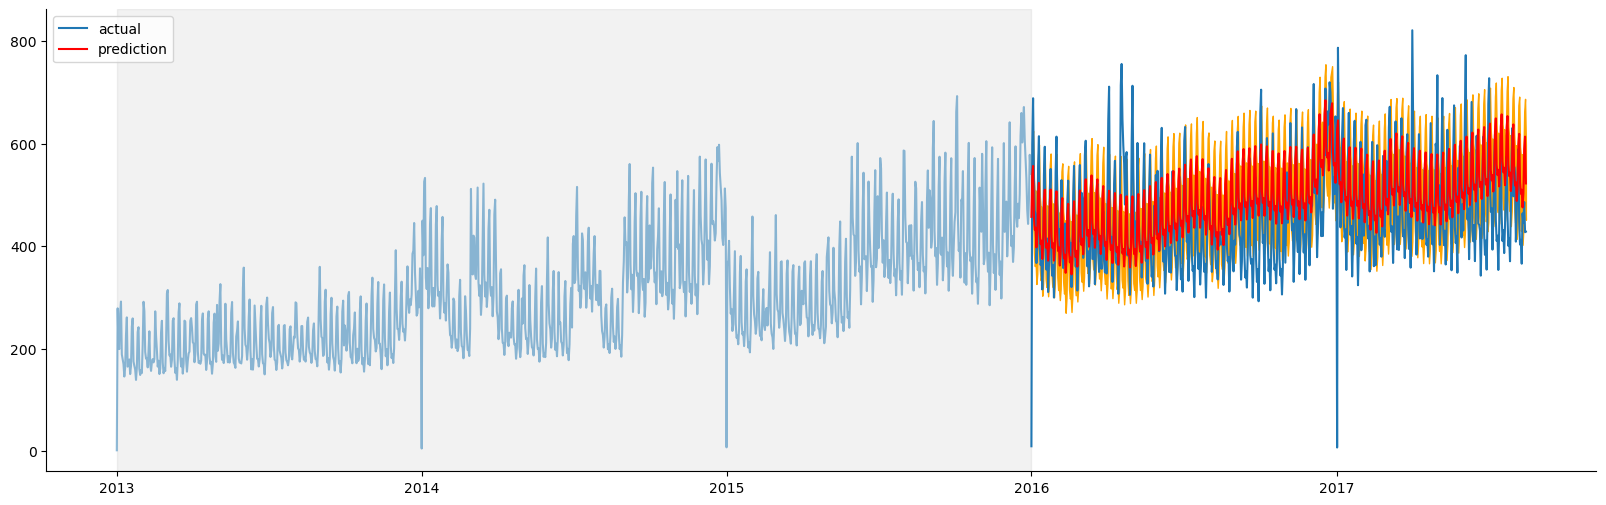

In [78]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(train['ds'], train['y'], alpha=0.5)
ax.plot(test['ds'], test['y'], color='tab:blue', label='actual')
ax.plot(test['ds'], test['yhat'], color='red', label='prediction')

plt.fill_between(x=test['ds'], y1=test['yhat_lower'], y2=test['yhat_upper'], color='orange')

ax.axvspan(train['ds'].min(), train['ds'].max(), color='#808080', alpha=0.1)

plt.legend(loc='upper left')
sns.despine()

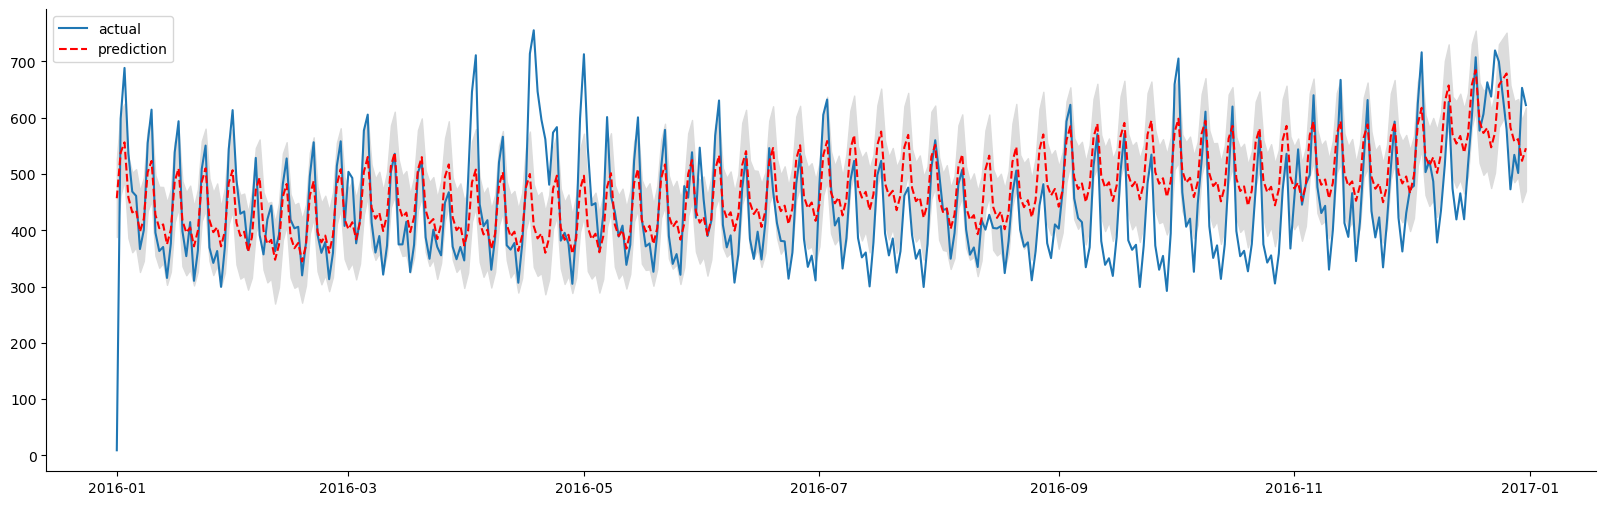

In [81]:
# plotting for only 1 year cycle
# throughout 2016 - 2017

temp = test[test['ds'] < '2017-01-01']

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(temp['ds'], temp['y'], color='tab:blue', label='actual')
ax.plot(temp['ds'], temp['yhat'], color='red', label='prediction', ls='--')

plt.fill_between(x=temp['ds'], y1=temp['yhat_lower'], y2=temp['yhat_upper'], color='gainsboro')

plt.legend(loc='upper left')
sns.despine()

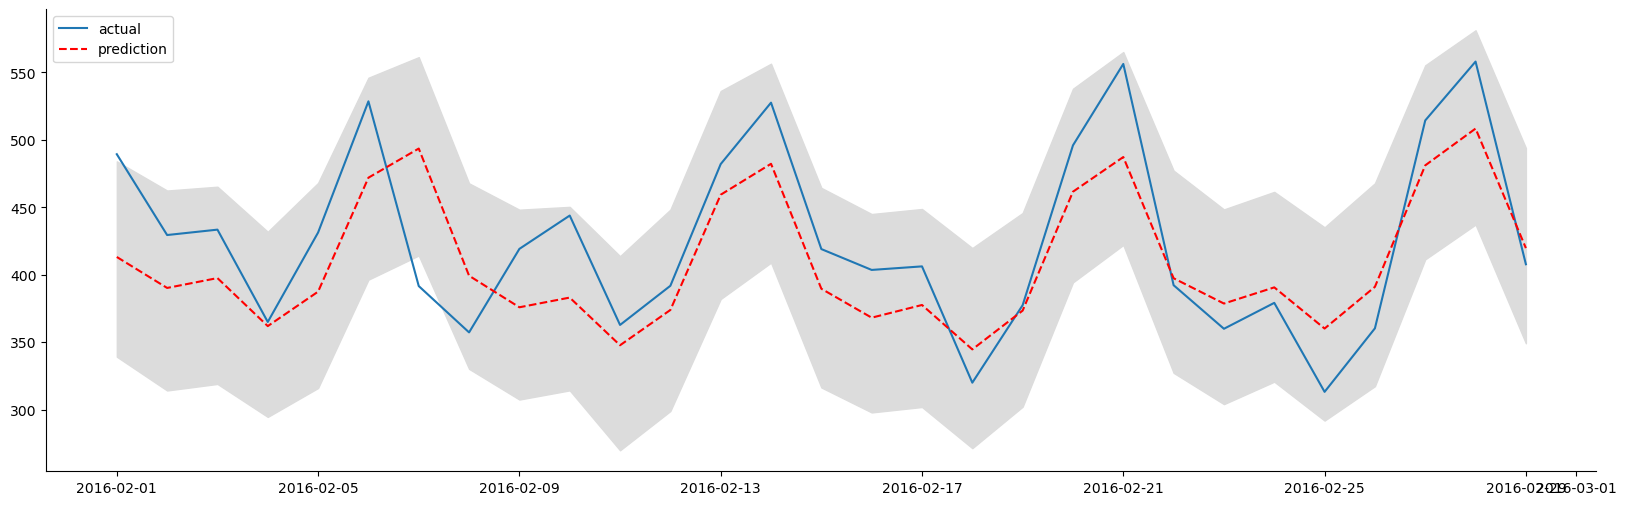

In [82]:
# to a month
# example using february 2016

temp = test.copy(deep=True)
temp['ds'] = pd.to_datetime(temp['ds'])
temp = temp[(temp['ds'] >= '2016-02-01') & (temp['ds'] < '2016-03-01')]

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(temp['ds'], temp['y'], color='tab:blue', label='actual')
ax.plot(temp['ds'], temp['yhat'], color='red', label='prediction', ls='--')

plt.fill_between(x=temp['ds'], y1=temp['yhat_lower'], y2=temp['yhat_upper'], color='gainsboro')

plt.legend(loc='upper left')
sns.despine()

## Prophet with Multivariate Model

For multivariate model, we couldn't make a prediction before we predict the independent variables itself. Thus, not like the univariate model, we couldn't make a prediction using test dataframe.

### Cleaning the Data

In [189]:
# create dummy variable for categorical variable
# dummy variable for type and locale

prophet_df_mul = df.copy(deep=True)
columns = ['type', 'locale']

for col in columns:
    dummies = pd.get_dummies(prophet_df_mul[col]).rename(columns=lambda x: f'{col}_' + str(x))
    prophet_df_mul = pd.concat([prophet_df_mul, dummies], axis=1)
    
print(prophet_df_mul.columns)
prophet_df_mul

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_store', 'cluster', 'type', 'locale', 'locale_name',
       'dcoilwtico', 'day_of_week', 'type_Event', 'type_Holiday',
       'type_Weekend', 'type_Work Day', 'locale_Local', 'locale_National',
       'locale_Regional'],
      dtype='object')


,id,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,...,locale_name,dcoilwtico,day_of_week,type_Event,type_Holiday,type_Weekend,type_Work Day,locale_Local,locale_National,locale_Regional
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,Ecuador,93.14,Tuesday,0,1,0,0,0,1,0
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,Ecuador,93.14,Tuesday,0,1,0,0,0,1,0
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,Ecuador,93.14,Tuesday,0,1,0,0,0,1,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,Ecuador,93.14,Tuesday,0,1,0,0,0,1,0
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,Ecuador,93.14,Tuesday,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047215,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,Riobamba,47.57,Tuesday,0,1,0,0,1,0,0
3047216,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,Riobamba,47.57,Tuesday,0,1,0,0,1,0,0
3047217,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,Riobamba,47.57,Tuesday,0,1,0,0,1,0,0
3047218,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,Riobamba,47.57,Tuesday,0,1,0,0,1,0,0


In [190]:
from itertools import product

type_col = [col for col in prophet_df_mul.columns if 'type_' in col]
type_col.remove('type_store')

loc_col = [col for col in prophet_df_mul.columns if 'locale_' in col]
loc_col.remove('locale_name')

interactions = list(product(type_col, loc_col))
interactions

[('type_Event', 'locale_Local'),
 ('type_Event', 'locale_National'),
 ('type_Event', 'locale_Regional'),
 ('type_Holiday', 'locale_Local'),
 ('type_Holiday', 'locale_National'),
 ('type_Holiday', 'locale_Regional'),
 ('type_Weekend', 'locale_Local'),
 ('type_Weekend', 'locale_National'),
 ('type_Weekend', 'locale_Regional'),
 ('type_Work Day', 'locale_Local'),
 ('type_Work Day', 'locale_National'),
 ('type_Work Day', 'locale_Regional')]

In [191]:
# creating interaction columns for type and locale dummy variable

for inter in interactions:
    prophet_df_mul[f'{inter[0]}_x_{inter[1]}'] = prophet_df_mul[inter[0]] * prophet_df_mul[inter[1]]

prophet_df_mul.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_store', 'cluster', 'type', 'locale', 'locale_name',
       'dcoilwtico', 'day_of_week', 'type_Event', 'type_Holiday',
       'type_Weekend', 'type_Work Day', 'locale_Local', 'locale_National',
       'locale_Regional', 'type_Event_x_locale_Local',
       'type_Event_x_locale_National', 'type_Event_x_locale_Regional',
       'type_Holiday_x_locale_Local', 'type_Holiday_x_locale_National',
       'type_Holiday_x_locale_Regional', 'type_Weekend_x_locale_Local',
       'type_Weekend_x_locale_National', 'type_Weekend_x_locale_Regional',
       'type_Work Day_x_locale_Local', 'type_Work Day_x_locale_National',
       'type_Work Day_x_locale_Regional'],
      dtype='object')

In [192]:
prophet_df_mul.drop(['id', 'store_nbr', 'family', 'city', 'state', 'type_store', 
                     'cluster', 'type', 'locale', 'locale_name', 'day_of_week'], axis=1, inplace=True)

# droping the independent dummy variable, can remove this one if it's considered could improve the model performance

prophet_df_mul.drop(['type_Event', 'type_Holiday', 'type_Weekend', 'type_Work Day', 
                     'locale_Local', 'locale_National', 'locale_Regional'], axis=1, inplace=True)

prophet_df_mul.columns

Index(['date', 'sales', 'onpromotion', 'dcoilwtico',
       'type_Event_x_locale_Local', 'type_Event_x_locale_National',
       'type_Event_x_locale_Regional', 'type_Holiday_x_locale_Local',
       'type_Holiday_x_locale_National', 'type_Holiday_x_locale_Regional',
       'type_Weekend_x_locale_Local', 'type_Weekend_x_locale_National',
       'type_Weekend_x_locale_Regional', 'type_Work Day_x_locale_Local',
       'type_Work Day_x_locale_National', 'type_Work Day_x_locale_Regional'],
      dtype='object')

In [193]:
# creating aggregate dictionary
# for groupby later

agg_dict = {}

for col in prophet_df_mul.columns:
    if col != 'date':
        if col == 'sales' or col == 'dcoilwtico':
            agg_dict[col] = 'mean'
        else:
            agg_dict[col] = 'sum'
            
agg_dict

{'sales': 'mean',
 'onpromotion': 'sum',
 'dcoilwtico': 'mean',
 'type_Event_x_locale_Local': 'sum',
 'type_Event_x_locale_National': 'sum',
 'type_Event_x_locale_Regional': 'sum',
 'type_Holiday_x_locale_Local': 'sum',
 'type_Holiday_x_locale_National': 'sum',
 'type_Holiday_x_locale_Regional': 'sum',
 'type_Weekend_x_locale_Local': 'sum',
 'type_Weekend_x_locale_National': 'sum',
 'type_Weekend_x_locale_Regional': 'sum',
 'type_Work Day_x_locale_Local': 'sum',
 'type_Work Day_x_locale_National': 'sum',
 'type_Work Day_x_locale_Regional': 'sum'}

In [194]:
prophet_df_mul.loc[:, (prophet_df_mul != 0).any(axis=0)]

,date,sales,onpromotion,dcoilwtico,type_Event_x_locale_National,type_Holiday_x_locale_Local,type_Holiday_x_locale_National,type_Holiday_x_locale_Regional,type_Weekend_x_locale_National,type_Work Day_x_locale_National
0,2013-01-01,0.000,0,93.14,0,0,1,0,0,0
1,2013-01-01,0.000,0,93.14,0,0,1,0,0,0
2,2013-01-01,0.000,0,93.14,0,0,1,0,0,0
3,2013-01-01,0.000,0,93.14,0,0,1,0,0,0
4,2013-01-01,0.000,0,93.14,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3047215,2017-08-15,438.133,0,47.57,0,1,0,0,0,0
3047216,2017-08-15,154.553,1,47.57,0,1,0,0,0,0
3047217,2017-08-15,2419.729,148,47.57,0,1,0,0,0,0
3047218,2017-08-15,121.000,8,47.57,0,1,0,0,0,0


In [195]:
prophet_df_mul = prophet_df_mul.groupby('date').agg(agg_dict)
prophet_df_mul = prophet_df_mul.reset_index()

# deleting impossible combination
# shown by column that only has zero value

prophet_df_mul = prophet_df_mul.loc[:, (prophet_df_mul != 0).any(axis=0)]

,date,sales,onpromotion,dcoilwtico,type_Event_x_locale_National,type_Holiday_x_locale_Local,type_Holiday_x_locale_National,type_Holiday_x_locale_Regional,type_Weekend_x_locale_National,type_Work Day_x_locale_National
0,2013-01-01,1.409438,0,93.14,0.0,0.0,1782.0,0.0,0.0,0.0
1,2013-01-02,278.390807,0,93.14,0.0,0.0,0.0,0.0,0.0,1782.0
2,2013-01-03,202.840197,0,92.97,0.0,0.0,0.0,0.0,0.0,1782.0
3,2013-01-04,198.911154,0,93.12,0.0,0.0,0.0,0.0,0.0,1782.0
4,2013-01-05,267.873244,0,93.12,0.0,0.0,0.0,0.0,1782.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1679,2017-08-11,463.733851,14179,48.81,0.0,0.0,1782.0,0.0,0.0,0.0
1680,2017-08-12,444.798280,8312,48.81,0.0,0.0,0.0,0.0,1782.0,0.0
1681,2017-08-13,485.768618,9283,48.81,0.0,0.0,0.0,0.0,1782.0,0.0
1682,2017-08-14,427.004717,8043,47.59,0.0,0.0,0.0,0.0,0.0,1782.0


In [208]:
# to make it into 1 or 2 scale
# 2 means that the day has 2 holiday / local

prophet_df_mul[[col for col in prophet_df_mul if 'type_' in col]] = prophet_df_mul[[col for col in prophet_df_mul if 'type_' in col]] / 1782

### Building the Model

In [255]:
# naming in a correct naming convention for prohet df

prophet_df_mul = prophet_df_mul.rename(columns={'date': 'ds',
                                                'sales': 'y'}) 

# splitting between test and train dataset

train_mul = prophet_df_mul[prophet_df_mul['ds'] < '2016-01-01']
test_mul = prophet_df_mul[prophet_df_mul['ds'] >= '2016-01-01']

In [256]:
regressor = [col for col in prophet_df_mul.columns if col != 'ds' and col != 'y']
regressor

['onpromotion',
 'dcoilwtico',
 'type_Event_x_locale_National',
 'type_Holiday_x_locale_Local',
 'type_Holiday_x_locale_National',
 'type_Holiday_x_locale_Regional',
 'type_Weekend_x_locale_National',
 'type_Work Day_x_locale_National']

In [293]:
m = Prophet()

for reg_var in regressor:
    m.add_regressor(reg_var)
    
m = m.fit(train_mul)
forecast_mul = m.predict(test_mul)

# need this one since we skip m.make_dataframe(), cannot do this since we will

test_mul = test_mul.reset_index(drop=True) 
test_mul[['yhat', 'yhat_lower', 'yhat_upper']] = forecast_mul[['yhat', 'yhat_lower', 'yhat_upper']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2242.11    0.00154658       184.122      0.3967           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2246.14    0.00040656       86.5313           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268          2247   9.14637e-05        79.471   9.584e-07       0.001      360  LS failed, Hessian reset 
     299       2247.11   4.48394e-05       64.5781      0.7995      0.7995      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2247.94     1.281e-06       72.0942      0.7424      0.7424      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       2247.94   2.47753e-07    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


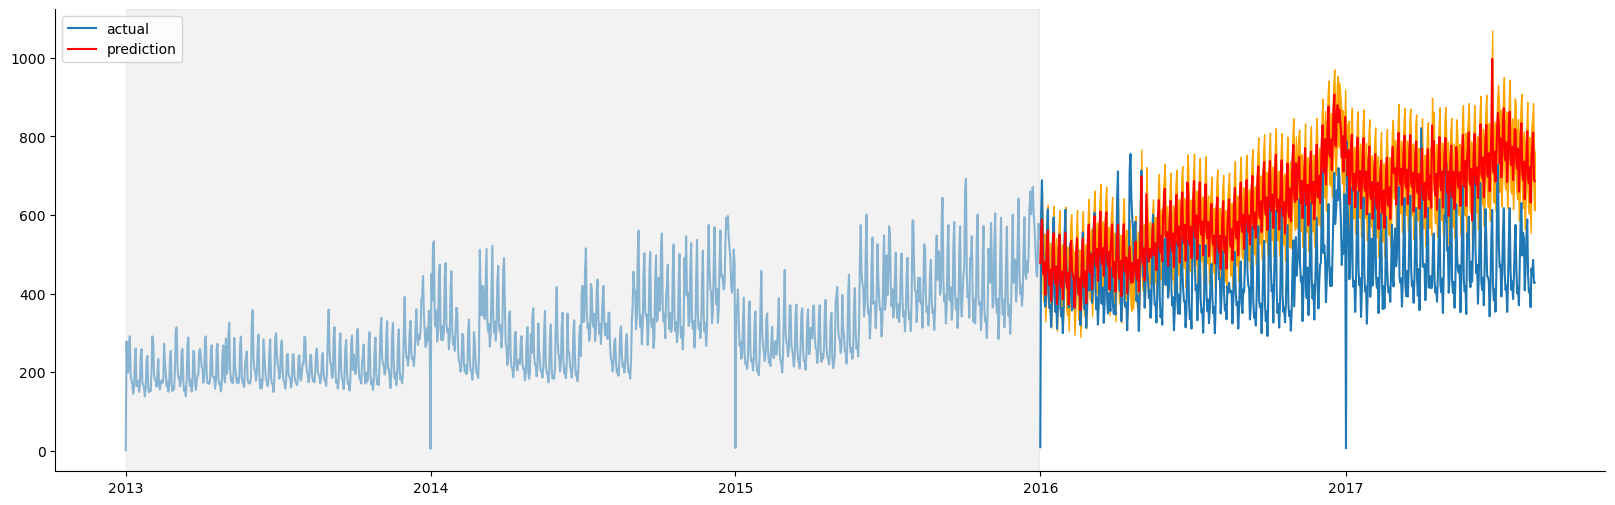

In [294]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(train_mul['ds'], train_mul['y'], alpha=0.5)
ax.plot(test_mul['ds'], test_mul['y'], color='tab:blue', label='actual')
ax.plot(test_mul['ds'], test_mul['yhat'], color='red', label='prediction')

plt.fill_between(x=test_mul['ds'], y1=test_mul['yhat_lower'], y2=test_mul['yhat_upper'], color='orange')

ax.axvspan(train_mul['ds'].min(), train_mul['ds'].max(), color='#808080', alpha=0.1)

plt.legend(loc='upper left')
sns.despine()

### Hyperparameter Tuning and Cross Validation

In [299]:
from tqdm import tqdm  # to monitor for-loop progress

maes = []

for params in tqdm(all_params_simple):  # using all_params_simple, can use all_params instead to explore every parameters
    # fitting the hyperparameter to prophet model
    m = Prophet(**params)
    
    # adding regressor
    for reg_var in regressor:
        m.add_regressor(reg_var)
    
    m = m.fit(train_mul)  # pass every parameters from all_params to Prophet
    df_cv = cross_validation(m, 
                             horizon='365 days', 
                             period='180 days', 
                             initial='365 days',
                             parallel='processes')  # speed up the process by setting the parallel parameter to "processes"
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params_simple)
tuning_results['mae'] = maes

  0%|          | 0/16 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe5f27dfd60>


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2156.81    0.00103399       5105.44           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2165.2   2.71106e-07       5125.04      0.7557      0.7557      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242        2165.2   5.18316e-09       5321.94      0.6323      0.6323      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1129.01   4.27008e-05       5116.88           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     190       1144.73   2.61218e-09        4885.3      0.2812      0.2812      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0       379.562       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -135.782
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    297.481. Improved by 433.264.
      84       761.031   2.22428e-07       5079.93    4.54e-11       0.001      158  LS failed, Hessian reset 
      98       761.032   5.85654e-09       5066.86      0.3271      0.3271      176   
Optimization terminated

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    549.555. Improved by 252.074.
Iteration  3. Log joint probability =    732.214. Improved by 182.659.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  4. Log joint probability =    793.267. Improved by 61.0527.
Iteration  5. Log joint probability =    796.559. Improved by 3.29253.
Iteration  6. Log joint probability =    797.518. Improved by 0.958886.
Iteration  7. Log joint probability =    806.538. Improved by 9.01986.
Iteration  8. Log joint probability =     806.81. Improved by 0.271558.
Iteration  9. Log joint probability =    806.941. Improved by 0.131828.
Iteration 10. Log joint probability =    807.046. Improved by 0.104338.
Iteration 11. Log joint probability =    807.135. Improved by 0.0889575.
Iteration 12. Log joint probability =    807.172. Improved by 0.0376191.
Iteration 13. Log joint probability =     807.24. Improved by 0.0674951.
Iteration 14. Log joint probability =    807.271. Improved by 0.0312548.
Iteration 15. Log joint probability =    807.276. Improved by 0.0044783.
Iteration 16. Log joint probability =     807.29. Improved by 0.0147772.
Iteration 17. Log joint probability =    807.296. Improved by

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▋         | 1/16 [00:25<06:26, 25.77s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2182.93    0.00300672       5051.79      0.8948      0.8948      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       2205.58    9.0795e-09       4924.29      0.5737      0.5737      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe75ec27880>
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1514.12    0.00499168       5059.97      0.3467      0.9907      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     151       1524.13   0.000425332       4987.33   7.997e-08       0.001      216  LS failed, Hessian reset 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0       379.562       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -195.649
     183        1525.6   3.96142e-06       5105.12   7.911e-10       0.001      295  LS failed, Hessian reset 
     199       1525.61   4.32753e-08       5090.52           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       1525.61    2.9842e-09       4754.74      0.1691      0.1691      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint 

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     164       1109.64   6.57983e-09       5035.22      0.4194      0.4194      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    678.705. Improved by 186.589.
Iteration  4. Log joint probability =    805.953. Improved by 127.247.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =    806.641. Improved by 0.687658.
Iteration  6. Log joint probability =    825.388. Improved by 18.7478.
Iteration  7. Log joint probability =    830.403. Improved by 5.01508.
Iteration  8. Log joint probability =    837.208. Improved by 6.80424.
Iteration  9. Log joint probability =    841.398. Improved by 4.19015.
Iteration 10. Log joint probability =    844.957. Improved by 3.55899.
Iteration 11. Log joint probability =    847.559. Improved by 2.60242.
Iteration 12. Log joint probability =     848.55. Improved by 0.990788.
Iteration 13. Log joint probability =    849.081. Improved by 0.53104.
Iteration 14. Log joint probability =    850.235. Improved by 1.15428.
Iteration 15. Log joint probability =    850.738. Improved by 0.50274.
Iteration 16. Log joint probability =    851.022. Improved by 0.28381.
Iteration 17. Log joint probability =     851.08. Improved by 0.0582147.
Iteration 18. Log joint probability =    851.206. Improved by 0.1259.
Ite

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▎        | 2/16 [00:50<05:51, 25.14s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2105.07    0.00344257       4999.72           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       2171.38   4.71912e-06       4871.83   9.251e-10       0.001      266  LS failed, Hessian reset 
     199       2171.41   1.33036e-06       5199.98           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       2171.42   5.72876e-09       5132.35      0.3654      0.3654      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0       379.562       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -255.517
Iteration  1. Log joint probability =    182.505. Improved by 438.021.
Iteration  2. Log joint probability =    419.249. Improved by 236.744.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    664.258. Improved by 245.009.
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1046.82     0.0006862       4915.67           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       1048.13   5.69967e-09       4559.52      0.2882      0.2882      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  4. Log joint probability =    779.454. Improved by 115.196.
      99       1515.72     0.0008714       5170.12      0.9504      0.9504      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  5. Log joint probability =     825.99. Improved by 46.5357.
     170       1522.49   1.90773e-07       5047.11   3.845e-11       0.001      243  LS failed, Hessian reset 
     180       1522.49   6.57077e-09        4614.8      0.2665      0.2665      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  6. Log joint probability =    826.074. Improved by 0.0838855.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =    830.435. Improved by 4.36135.
Iteration  8. Log joint probability =    849.533. Improved by 19.0978.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =    850.134. Improved by 0.600865.
Iteration 10. Log joint probability =    851.794. Improved by 1.65994.
Iteration 11. Log joint probability =    852.064. Improved by 0.270317.
Iteration 12. Log joint probability =    852.105. Improved by 0.04091.
Iteration 13. Log joint probability =    852.251. Improved by 0.146166.
Iteration 14. Log joint probability =    852.268. Improved by 0.0170131.
Iteration 15. Log joint probability =    852.341. Improved by 0.0723704.
Iteration 16. Log joint probability =    852.341. Improved by 0.000180126.
Iteration 17. Log joint probability =    852.342. Improved by 0.000751488.
Iteration 18. Log joint probability =    852.342. Improved by 9.53722e-05.
Iteration 19. Log joint probability =    852.343. Improved by 0.000810083.
Iteration 20. Log joint probability =    852.343. Improved by 1.10018e-05.
Iteration 21. Log joint probability =    852.343. Improved by 0.000869056.
Iteration 22. Log joint probability =    852.3

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 3/16 [01:26<06:29, 29.99s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2067.94     0.0135803       5213.81           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2206.62   7.36744e-07       5052.67      0.5409      0.5409      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2206.63   6.34144e-09       5064.91      0.3414      0.3414      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1047.04   3.03111e-07       5311.96      0.4469      0.4469      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       1059.08   9.18597e-09       4785.81      0.3779      0.3779      220   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -16.8463             0       379.562       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -315.384


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  1. Log joint probability =    190.509. Improved by 505.893.
Iteration  2. Log joint probability =     410.91. Improved by 220.401.
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    644.859. Improved by 233.948.
      99       1509.19   0.000537231       5107.54      0.8071      0.8071      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       1526.08   6.92941e-09       4814.77      0.3765      0.3765      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  4. Log joint probability =    821.537. Improved by 176.679.
Iteration  5. Log joint probability =    827.043. Improved by 5.50579.
Iteration  6. Log joint probability =    827.115. Improved by 0.0721073.


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  7. Log joint probability =     831.36. Improved by 4.24489.
Iteration  8. Log joint probability =    849.657. Improved by 18.2969.
Iteration  9. Log joint probability =     850.04. Improved by 0.383538.
Iteration 10. Log joint probability =    851.791. Improved by 1.75086.
Iteration 11. Log joint probability =    852.083. Improved by 0.291983.
Iteration 12. Log joint probability =    852.119. Improved by 0.0352689.
Iteration 13. Log joint probability =    852.273. Improved by 0.154123.
Iteration 14. Log joint probability =    852.273. Improved by 0.000356167.
Iteration 15. Log joint probability =    852.274. Improved by 0.00130067.
Iteration 16. Log joint probability =    852.275. Improved by 0.00046261.
Iteration 17. Log joint probability =    852.276. Improved by 0.00109431.
Iteration 18. Log joint probability =    852.276. Improved by 0.000571954.
Iteration 19. Log joint probability =    852.277. Improved by 0.000890773.
Iteration 20. Log joint probability =    852.278. I

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▌       | 4/16 [01:52<05:44, 28.71s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2187.95   0.000489559       320.866      0.7534      0.7534      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       2188.62   0.000453611       391.424   9.321e-07       0.001      176  LS failed, Hessian reset 
     190       2188.83   1.57243e-06       376.142   3.261e-09       0.001      312  LS failed, Hessian reset 
     199       2188.83   4.78837e-08       334.474      0.1814           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2188.83   3.16689e-08       347.304           1           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       806.533   1.19744e-05       505.155      0.2414      0.5888      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127        806.54   9.60552e-09        517.08      0.3379      0.3379      152   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      93       1116.48    0.00346661       607.604   7.945e-06       0.001      155  LS failed, Hessian reset 
      99       1117.22   0.000639482       363.853           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||d

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     134       1117.46   0.000112595       457.186   2.445e-07       0.001      237  LS failed, Hessian reset 
     199       1117.48   7.39016e-08       350.956      0.3952           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       1117.48   1.42106e-06       500.464   2.761e-09       0.001      371  LS failed, Hessian reset 
      99       1501.18   6.41802e-05       414.816      0.6694      0.6694      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       1117.49   3.32764e-09        358.18      0.1791      0.1791      394   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     138       1501.23    7.2558e-06       465.661   1.718e-08       0.001      211  LS failed, Hessian reset 
     179       1501.24   8.92243e-09       457.707      0.4091      0.4091      271   
Optimization terminated normal

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       2226.04    0.00427422       513.573   1.065e-05       0.001      140  LS failed, Hessian reset 
      99       2226.87   4.92313e-05       277.337      0.3894           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       2226.93   1.16268e-05       329.899   2.402e-08       0.001      290  LS failed, Hessian reset 
     199       2226.93    4.9853e-08       330.592           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       2226.93   2.02483e-08       371.067      0.2374           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       848.177    5.7744e-05       507.635      0.3388           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       850.566   1.89957e-06       493.634   3.727e-09       0.001      237  LS failed, Hessian reset 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     195       850.567   4.83255e-08       496.172   9.438e-11       0.001      310  LS failed, Hessian reset 
     199       850.567   4.68613e-08       500.315           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       850.567   8.97231e-10        502.26     0.07551     0.07551      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       1533.39   0.000500066        502.87           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1534.57    0.00112817       507.974   1.977e-06       0.001      195  LS failed, Hessian reset 
      99        1158.4    0.00289176       681.725      0.1466           1      136   
    Iter

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     297       1159.88   0.000161456       491.715   3.907e-07       0.001      441  LS failed, Hessian reset 
     299       1159.91   5.37672e-05       381.398      0.8571      0.8571      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1160.04   4.99718e-06       402.881      0.6476      0.6476      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     429       1160.04   6.92937e-09       461.315      0.2412      0.8481      603   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2226.74    0.00244419       419.124   4.971e-06       0.001      148  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       2227.37   1.34317e-05       320.291   2.809e-08       0.001      271  LS failed, Hessian reset 
     199       2227.38   3.82709e-07       345.735       0.292      0.7751      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       2227.39   1.96672e-05       319.316   4.311e-08       0.001      397  LS failed, Hessian reset 
     295       2227.39    3.7711e-08       380.905      0.3647           1      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1534.61    0.00587814       394.632           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1535.75    0.00087127       569.638   1.977e-06       0.001      172  LS failed, Hessian reset 
     199       1536.38   1.47276e-07        390.93           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     229       1536.39   6.08749e-06       459.691    1.27e-08       0.001      370  LS failed, Hessian reset 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       1536.39   2.29897e-09       385.152     0.08155     0.08155      402   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       850.544   8.36698e-06       488.116      0.4377      0.4377      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       850.611   7.28145e-05       502.148   1.498e-07       0.001      173  LS failed, Hessian reset 
     142       850.635   4.85817e-09       448.844      0.2524      0.2524      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||     

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     241       1160.54   1.64603e-06       626.206   4.297e-09       0.001      434  LS failed, Hessian reset 
     256       1160.54    9.4371e-09       353.066      0.2305      0.7445      454   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 7/16 [03:03<03:43, 24.85s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2227.23   0.000110104       308.964      0.2145           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2227.46   4.61362e-06       470.595           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       2227.46   1.19336e-06           455   2.585e-09       0.001      303  LS failed, Hessian reset 
     221       2227.46   7.95824e-09       338.851      0.1257      0.1257      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       1159.13    0.00630077       511.497   1.269e-05       0.001      140  LS failed, Hessian reset 
      99       1160.03   0.000156112       357.704      0.7227      0.7227      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1160.51    1.6596e-05       417.081      0.7622      0.7622      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       1160.52   3.46978e-06       453.525   5.923e-09       0.001      340  LS failed, Hessian reset 
Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       851.038   1.75511e-07       498.254      0.4253      0.4253      123   
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

      99       1533.53   0.000300923        427.93      0.4102      0.4102      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       1536.38   3.95818e-05       464.145   8.754e-08       0.001      298  LS failed, Hessian reset 
     199       1536.39   1.54597e-05       373.547           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259        1536.4   1.34383e-06       465.743   3.554e-09       0.001      404  LS failed, Hessian reset 
     285        1536.4    9.4883e-09       340.059       0.303           1      442   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|█████     | 8/16 [03:26<03:15, 24.41s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoff

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2219.34    0.00765306       162.938      0.6309      0.6309      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2225.46     0.0249958       159.774           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2231.76    0.00360172       73.7472           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2233.32     0.0245204       113.358      0.6249      0.6249      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2236.44    0.00121017       59.4648      0.9834      0.9834      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       804.337     0.0213756       98.5945           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       808.328    0.00217565       106.453   1.851e-05       0.001      238  LS failed, Hessian reset 
     199       808.868   0.000484282       31.0533           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       809.492    8.2175e-05       39.6265           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       809.546   0.000310649       36.0282   8.407e-06       0.001      455  LS failed, Hessian reset 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       809.641   1.21448e-05       44.9357           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       809.646   0.000133441       48.6663    2.91e-06       0.001      599  LS failed, Hessian reset 
     449        809.65   2.06585e-06         34.02   4.075e-08       0.001      688  LS failed, Hessian reset 
     463        809.65   6.48262e-08       46.5577      0.5852      0.5852      706   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1505.42    0.00448908       120.536      0.8978      0.8978      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       1506.21   0.000871932       41.9354           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1132.8     0.0053038        62.855           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       1506.34    0.00135843       78.6855   2.689e-05       0.001      289  LS failed, Hessian reset 
     199       1134.06   3.04965e-05       38.7832     0.09287      0.3172      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       1506.43   0.000145164       34.1089   3.211e-06       0.001      393  LS failed, Hessian reset 
     299       1506.44   4.03771e-05       42.7803      0.6575      0.6575      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1134.15   0.000582878        37.872           1

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2255.66   0.000350834       156.261      0.3087      0.3087      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2261.28    0.00175101       251.797      0.1865           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2264.72      0.018549       73.7728      0.3261      0.3261      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2266.77    0.00170036       77.9508           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2267.91   0.000616743       37.3096           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        846.39    0.00895551       80.3817           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       850.239    2.7169e-05       43.6755           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       851.188   0.000527198       46.3496           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       851.322   0.000470919       53.7232   8.429e-06       0.001      471  LS failed, Hessian reset 
     399       851.358   4.33346e-06       48.8107      0.4165      0.4165      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     414       851.358    8.1421e-08    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1544.1   0.000418096       59.8312      0.3564      0.3564      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1173.99     2.638e-05       26.6794      0.3957      0.3957      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       1544.74   0.000348706       80.9163   6.639e-06       0.001      216  LS failed, Hessian reset 
     199       1544.82   0.000178785       46.4823           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1175.03   3.20299e-05       25.8409      0.2007      0.6174      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1545.03   0.000142457    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2256.39    0.00580769       240.026      0.2298           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2263.18     0.0022687       61.3393           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2265.26     0.0162943        96.416           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2267.27    0.00222189       40.5677           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       2267.86     0.0004149       115.451   8.297e-06       0.001      531  LS failed, Hessian reset 
     499       2268.42   7.56472e-05    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       847.647      0.014455       133.698           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       852.287   0.000105836       54.4909      0.4205      0.4205      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205        852.39    0.00069578       104.864   8.544e-06       0.001      286  LS failed, Hessian reset 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       852.434   1.81109e-05       54.6785   3.472e-07       0.001      406  LS failed, Hessian reset 
     294       852.436   3.79444e-08        48.359      0.2976           1      439   
Optimization terminated normally: 
  Convergence detected: relative

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99       1544.62   0.000532102       65.0851      0.1685      0.1685      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     147       1545.12    0.00127601       122.022   2.222e-05       0.001      208  LS failed, Hessian reset 
     199       1545.18   2.13527e-05       41.6883           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     222       1545.33    0.00155011       105.442   3.139e-05       0.001      328  LS failed, Hessian reset 
     299        1545.5    0.00057406       41.4872           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       1545.62   0.000686806       48.0083   1.393e-05       0.001      483  LS failed, Hessian reset 
     399       1545.67   0.000495478       45.4919           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       1545.67   2.74827e-07       42.8486      0.1677      0.5499      635   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▉   | 11/16 [04:38<02:04, 24.83s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2256.5    0.00708711       132.587       0.271           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2263.38     0.0169249       100.942           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2265.15   0.000395592       38.2764      0.6755      0.6755      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       2265.52    0.00031526       94.5508   1.774e-06       0.001      406  LS failed, Hessian reset 
     388       2266.54   0.000201558       76.1007   2.103e-06       0.001      532  LS failed, Hessian reset 
     399       2266.72   0.000604727       52.4967      0.7298      0.7298      543   
    Iter      log pro

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       847.932   0.000910629       130.944      0.6915      0.6915      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       852.207   0.000194298       55.2498           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       852.384   0.000182692       55.8698   2.919e-06       0.001      336  LS failed, Hessian reset 
     296         852.4   2.23662e-08       49.6183      0.2123      0.2123      383   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1544.75    0.00245898       55.7013           1           

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      85       1174.78   0.000220329       41.1178   3.512e-06       0.001      139  LS failed, Hessian reset 
      99        1174.8   6.88123e-05       29.2822      0.1565           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       1545.62    3.5694e-05       42.8477   9.897e-07       0.001      379  LS failed, Hessian reset 
     106        1174.8   4.11654e-05       31.4845   1.399e-06       0.001      201  LS failed, Hessian reset 
     299       1545.64   0.000269656       42.8983           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1175.63   0.000528877        36.445      0.9454      0.9454      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       1545.69    0.00020564       46.0263           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1175.81   0.000310097       37.1638   1.271e-05       0.001      416  LS failed, Hessian reset 
     299       1175.85   0.000915461       46.3707           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        1175.9   0.000165642       23.7781   5.059e-06       0.001      546  LS failed, Hessian reset 
     489        1545.7   2.97842e-07       43.8836      0.5923      0.5923      664   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       1175.92    1.4331e-05       22.4848      0.2401           1      631   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     455       1175.96   0.000161837        44.312   4.496e-06       0.001      738  LS failed, Hessian reset 
     499       1175.98   0.000264425       41.0563           1           1      792   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     599          1176   1.14628e-05       43.7716           1           1      912   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     627       1176.02   0.000365505       30.7063   7.578e-06       0.001      984  LS failed, Hessian reset 
     699       1176.03   3.84517e-06       37.2281       1.211      0.1211     1081   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     753       1176.03    2.9159e-07       36.4005      0.1956           1     1163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▌  | 12/16 [05:00<01:35, 23.94s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2241.33   0.000660666       176.461      0.5066      0.5066      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2304.91     0.0163117       133.084           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2322.31    0.00912414       149.089           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2326.85    0.00062811       54.4746      0.2796           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2329.94     0.0256475       121.136           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       812.485    0.00998442       75.4773           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       813.978     0.0186347       91.7338      0.2345           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       815.193   0.000486924       28.5498      0.6801      0.6801      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        815.62    0.00119717       9.00443           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       815

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       1145.38    0.00429344       50.9905           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        816.37   0.000823692       9.87005           1           1      971   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1516.94    0.00682797       118.769      0.9751      0.9751      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       1145.93   0.000270659       46.3819   3.191e-06       0.001      477  LS failed, Hessian reset 
     824       816.408   0.000103601       15.8776   3.188e-06       0.001     1043  LS failed, Hessian reset 
     399        1146.3    0.00786108       32.6348           1           1      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       816.452   0.000385369       8.74096      0.6477

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     599       1526.58   0.000532923       20.3685           1           1      656   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     988       1148.43   8.53489e-05        15.815   3.118e-06       0.001     1222  LS failed, Hessian reset 
     999       1148.45    0.00047048       9.88085           1           1     1233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     645       1526.62   4.73126e-05       11.3589   2.696e-06       0.001      755  LS failed, Hessian reset 
    1076        1148.5   0.000177252       24.5867   8.624e-06       0.001     1355  LS failed, Hessian reset 
    1099       1148.52   0.000742609       10.5801           1           1     1379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     692       1526.66   0.000252603       24.5315   1.848e-05       0.001      850  LS failed, Hessian reset 
     699       1526

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     832       1526.74   6.12404e-06       8.66432   8.639e-07       0.001     1055  LS failed, Hessian reset 
     861       1526.74    1.8457e-06       5.94732     0.06692           1     1091   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████▏ | 13/16 [05:25<01:13, 24.41s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-01-05 00:00:00 and 2014-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe75f62c0d0>


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2292.73    0.00475579       225.913           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          2349    0.00579324       154.016           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2357.25    0.00789796       109.699           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2359.43    0.00556499       226.651      0.4946           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2364.43    0.00511251       123.103      0.1845           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       849.588    0.00437897       66.0461      0.4558           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        850.26    0.00542512       18.5713           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       850.735   0.000966527       24.5883      0.4384      0.4384      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        851.04   6.00077e-05       9.26348       0.822       0.822      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       851

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     610       851.324   0.000353965       42.4877   2.235e-05       0.001      828  LS failed, Hessian reset 
     199       1184.12    0.00165945       36.1988           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       851.366   8.47612e-05       8.70529      0.8457      0.8457      935   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1186.43     0.0153977       69.7885           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     760       851.368   1.19038e-06       8.17038      0.4827      0.4827     1012   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       1188.51     

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299        1556.9    0.00813532        30.961      0.3849           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1191.49    0.00154903       16.7642           1           1      794   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1192.22   0.000587076         14.53      0.8091      0.8091      904   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1557.62    0.00927144       76.0735           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1192.34   0.000488285       9.66755      0.4324      0.4324     1019   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1558.59   0.000222632       14.6538           1           1      555   
    Iter      log 

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     899       1559.45   1.14251e-05       7.94962      0.4497      0.4497     1020   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1559.58   0.000115843       7.06938      0.2459           1     1142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1559.68   8.65124e-06       6.53284      0.8703      0.8703     1261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       1559.76     0.0107602       29.3515       0.294           1     1374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1228       1559.86   0.000118557       24.0856   4.994e-06       0.001     1438  LS failed, Hessian reset 
    1299       1559.99    0.00222366       17.4619      0.3524           1     1517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 14/16 [05:54<00:51, 25.57s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2293.16    0.00954955       874.864      0.1619      0.1619      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2351.44    0.00522536       130.901           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2358.38    0.00639654       75.0903           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2361.27    0.00694572       49.2656           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2366.94   0.000395042       24.9224           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       850.607     0.0114231       82.8252           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       851.378    0.00200005        17.807           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        851.85     0.0265427       32.5436           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       852.335   0.000241861       11.1434      0.3493      0.3493      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       852.429   7.74604e-05       15.7453   3.402e-06       0.001      585  LS failed, Hessian reset 
     499       852.448   2.71993e-06    

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1183.45     0.0314737       183.014           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1187.58     0.0068049       33.0979      0.7684      0.7684      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       1189.41    0.00404229       71.0718           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1553.31      0.031663        129.63           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1190.39    0.00299078        17.869           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1556.56      0.010809       110.855           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1191.33    0.00101151         52.23      0.0166           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1557.44    0.00060449       14.6196           1           1      322   
    Iter      log 

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1099       1560.63   0.000121008       6.03109           1           1     1315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1128       1560.67   0.000227483       21.1506   7.683e-06       0.001     1385  LS failed, Hessian reset 
    1199        1560.7    0.00012997       18.6982      0.4302      0.4302     1459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       1560.73    0.00406412       12.9663      0.9537      0.9537     1574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1354        1560.8    3.7225e-05       9.79488   2.988e-06       0.001     1672  LS failed, Hessian reset 
    1399       1560.81   7.65371e-06       6.09665      0.5877      0.5877     1724   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1437       1560.81   3.19274e-05       7.06963   4.004e-06

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 15/16 [06:18<00:25, 25.17s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 3 forecasts with cutof

Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2293.08     0.0500012       312.535           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2350.46    0.00612322         143.5           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2356.82    0.00763801       95.3735      0.4776           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2359.3    0.00555963       83.4846      0.5518      0.5518      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2364.59   0.000563158       34.8651           1           1      542   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       850.584    0.00367815       37.8143       0.481           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       851.265    0.00528815       42.7135      0.7087      0.7087      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       851.481   0.000145981       20.8426    2.76e-06       0.001      299  LS failed, Hessian reset 
     299       851.898    0.00124825       15.3384       0.545      0.8556      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       852.041   0.000169537        28.169   3.024e-06       0.001      477  LS failed, Hessian reset 
Initial log joint probability = -15.4465
    Iter      log prob        ||dx||      ||grad||       alpha     

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199       1185.16    0.00286534       37.2233           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     565       852.449   0.000288291        12.366   2.576e-05       0.001      796  LS failed, Hessian reset 
Initial log joint probability = -14.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       852.459   1.14134e-05       7.55507       0.206       0.206      843   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       852.462   3.25582e-06       9.30579      0.9149      0.9149      958   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     725       852.462   7.17272e-07       8.60304      0.2491      0.9979      986   
     299       1190.98    0.00832527       88.1222      0.5904      0.5904      334   
Optimization terminated normally: 
  Convergen

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     599       1193.38    0.00131113        18.435           1           1      674   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1557.52   0.000928864       17.9967           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     648       1193.49   0.000123169       23.4844   8.347e-06       0.001      762  LS failed, Hessian reset 
     699       1193.57    0.00014395       9.55435           1           1      821   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399       1557.96   0.000133082       26.4612      0.7009      0.7009      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     715       1193.62   0.000125723       18.9675   2.348e-06       0.001      884  LS failed, Hessian reset 
     771       1193.74   0.000158233       19.4111   1.558e-05       0.001      989  LS failed, Hessian reset 
     499        1559.3    0.00177024       48.1074           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1193.75   1.34627e-05       7.75298      0.4477      0.4477     1019   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899          1194   0.000182681       11.4699      0.7987      0.7987     1130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1559.57   0.000585041        12.006           1

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     699       1559.83    0.00151315       12.2743           1           1      784   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799          1560   8.79305e-05       7.22611      0.5372      0.5372      900   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     899        1560.3    0.00811746       51.9475           1           1     1005   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     912       1560.47   0.000175271       43.7872   4.646e-06       0.001     1054  LS failed, Hessian reset 
     999       1560.62   8.40653e-05       8.24217      0.8268      0.8268     1160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1560.69   0.000482134        17.277      0.6769      0.6769     1279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       1560.77   0.000227854       7.07642           1           1     1391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       1560.82    0.00308171       34.7143           1           1     1498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
100%|██████████| 16/16 [06:48<00:00, 25.53s/it]


In [302]:
tuning_results.sort_values('mae')

,changepoint_prior_scale,seasonality_prior_scale,mae
9,0.100,0.10,121.776139
11,0.100,10.00,122.697080
10,0.100,1.00,123.523157
8,0.100,0.01,124.230913
4,0.010,0.01,135.853820
13,0.500,0.10,141.444516
15,0.500,10.00,144.128330
14,0.500,1.00,149.230451
5,0.010,0.10,175.379466
7,0.010,10.00,176.221064


MAE is becoming higher now lol.

### Fitting the Parameters of the Best Model

In [304]:
# initiate the model to the variable
m = Prophet(changepoint_prior_scale=0.100,
            seasonality_prior_scale=0.10)

for reg_var in regressor:
    m.add_regressor(reg_var)

m = m.fit(train_mul)
forecast_mul = m.predict(test_mul)

test_mul = test_mul.reset_index(drop=True) 
test_mul[['yhat', 'yhat_lower', 'yhat_upper']] = forecast_mul[['yhat', 'yhat_lower', 'yhat_upper']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.9711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2255.66   0.000350834       156.261      0.3087      0.3087      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2261.28    0.00175101       251.797      0.1865           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2264.72      0.018549       73.7728      0.3261      0.3261      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2266.77    0.00170036       77.9508           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2267.91   0.000616743       37.3096           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


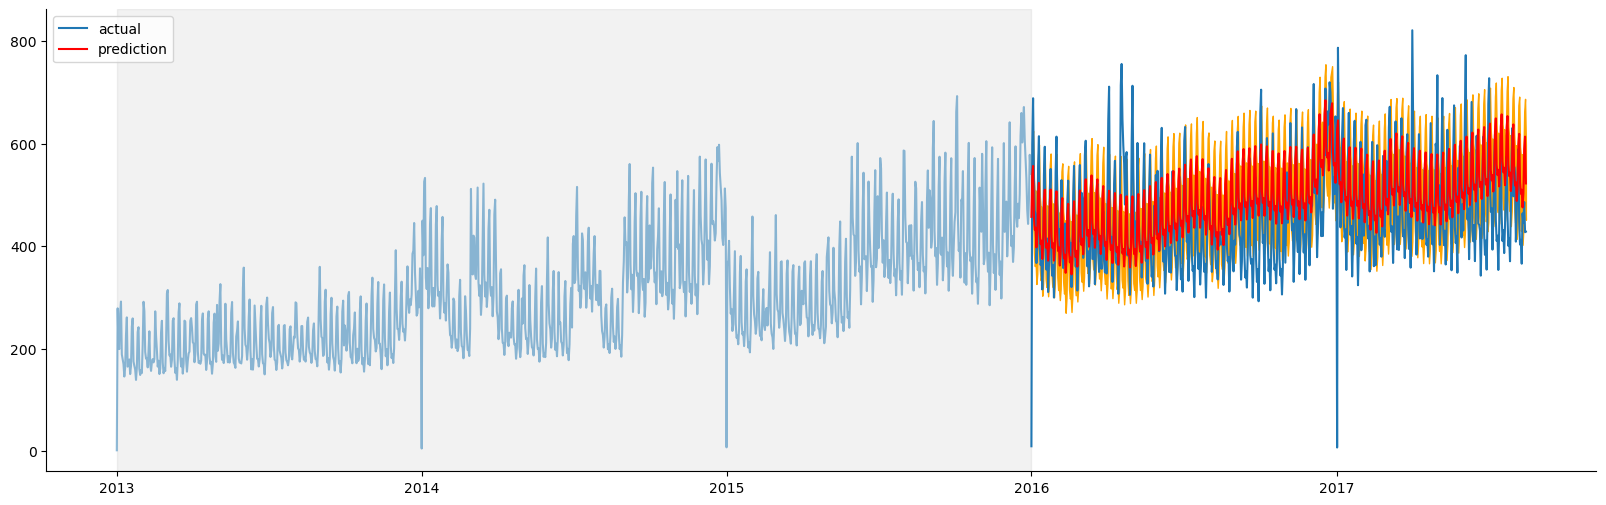

In [305]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(train['ds'], train['y'], alpha=0.5)
ax.plot(test['ds'], test['y'], color='tab:blue', label='actual')
ax.plot(test['ds'], test['yhat'], color='red', label='prediction')

plt.fill_between(x=test['ds'], y1=test['yhat_lower'], y2=test['yhat_upper'], color='orange')

ax.axvspan(train['ds'].min(), train['ds'].max(), color='#808080', alpha=0.1)

plt.legend(loc='upper left')
sns.despine()

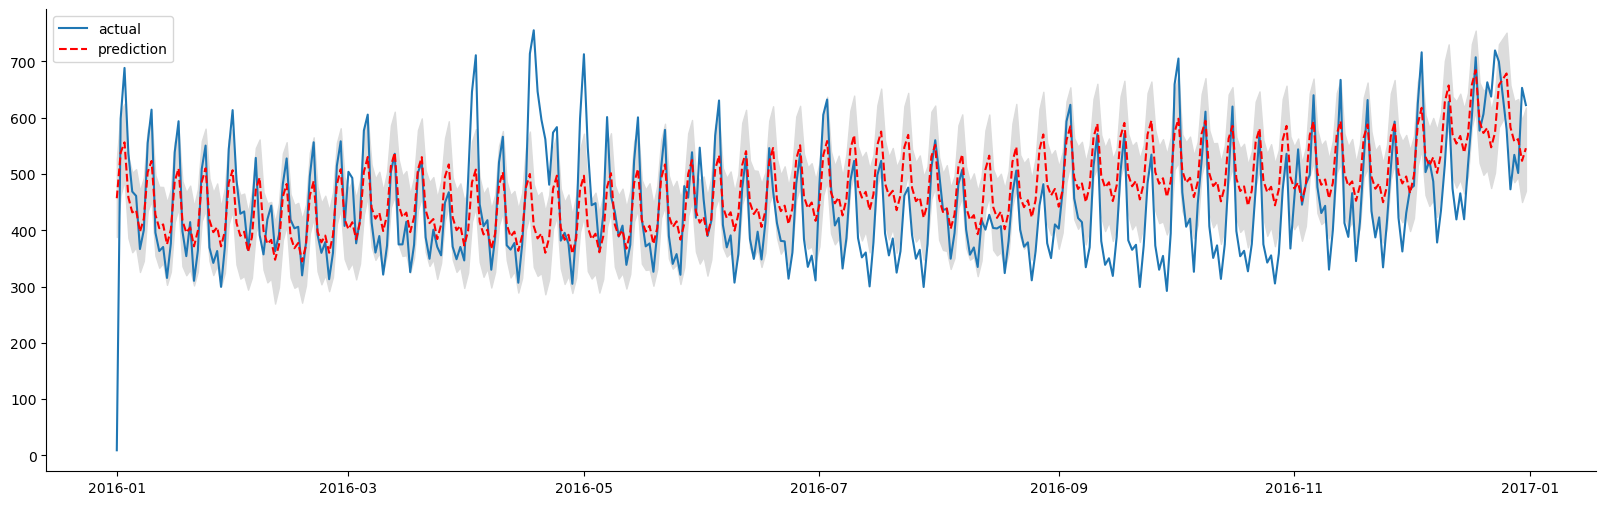

In [306]:
# plotting for only 1 year cycle
# throughout 2016 - 2017

temp = test[test['ds'] < '2017-01-01']

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(temp['ds'], temp['y'], color='tab:blue', label='actual')
ax.plot(temp['ds'], temp['yhat'], color='red', label='prediction', ls='--')

plt.fill_between(x=temp['ds'], y1=temp['yhat_lower'], y2=temp['yhat_upper'], color='gainsboro')

plt.legend(loc='upper left')
sns.despine()

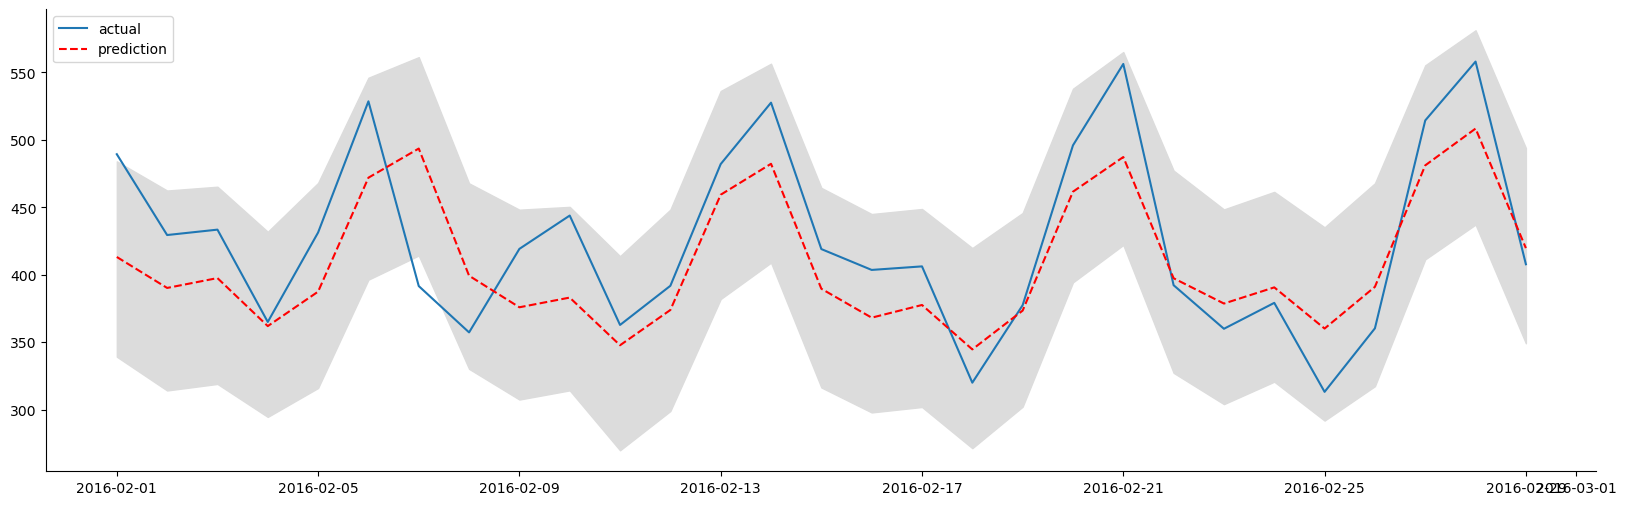

In [307]:
# to a month
# example using february 2016

temp = test.copy(deep=True)
temp['ds'] = pd.to_datetime(temp['ds'])
temp = temp[(temp['ds'] >= '2016-02-01') & (temp['ds'] < '2016-03-01')]

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(temp['ds'], temp['y'], color='tab:blue', label='actual')
ax.plot(temp['ds'], temp['yhat'], color='red', label='prediction', ls='--')

plt.fill_between(x=temp['ds'], y1=temp['yhat_lower'], y2=temp['yhat_upper'], color='gainsboro')

plt.legend(loc='upper left')
sns.despine()